
# **Imports & cấu hình chung**

In [18]:
# %% [markdown]
# # IDS Notebook — Pipeline 2-Phase + Save/Plot + Resume
# - Lưu mô hình dạng `.h5` vào D:\DACN\results\training\models
# - Ảnh biểu đồ vào D:\DACN\results\training\plots
# - Bảng so sánh vào D:\DACN\results\training\tables
# - Có thể **tiếp tục train** (resume) mà **không phải chạy lại** tiền xử lý.

import os, glob, io, time, json, warnings, joblib, random, pickle, math
from pathlib import Path
from typing import List, Dict, Tuple, Optional, Set

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_fscore_support, accuracy_score
)
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import lightgbm as lgb

warnings.filterwarnings("ignore")

# ==== PATHS (chỉnh theo máy bạn) ====
CIC2019_DIR = r'D:\DACN\dataset\CICDDoS2019'
CIC2017_DIR = r'D:\DACN\dataset\CICDDoS2017'
UNSW15_DIR  = r'D:\DACN\dataset\UNSW_NB15'
NSLKDD_DIR  = r'D:\DACN\dataset\NSL-KDD'   # có KDDTrain+.txt, KDDTest+.txt

# ==== nơi lưu kết quả ====
ROOT_SAVE = Path(r"D:\DACN\results\training")
DIR_MODELS = ROOT_SAVE / "models"
DIR_PLOTS  = ROOT_SAVE / "plots"
DIR_TABLES = ROOT_SAVE / "tables"
for p in [DIR_MODELS, DIR_PLOTS, DIR_TABLES]:
    p.mkdir(parents=True, exist_ok=True)

# ==== loại cột ID/time ====
EXCLUDE_ID_COLUMNS = True
ID_LIKE_COLS = set([
    'Flow ID','FlowID','Timestamp','StartTime','Start Time','stime','time','Date','datetime',
    'Src IP','Dst IP','Source IP','Destination IP',
    'srcip','dstip','srcip_addr','dstip_addr', 
    'Src Port','Dst Port','Sport','Dport','srcport','dstport',
    'ProtocolName','ProtoName','Service','service','state','attack_cat','label',
    'Unnamed: 0','id','No.','Index'
])
LABEL_CANDS = ["Label","label","Attack","attack","attack_cat","class","Class","target","category","Category","result"]

# kiểm soát lệch phân bố từ UNSW (toàn attack)
MAX_UNSW_RATIO = 0.30   # tối đa 30%
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)



# **Giới hạn CPU + TensorFlow threads**

In [19]:
# %%
import multiprocessing as mp

def limit_cpu(fraction: float = 0.90) -> int:
    """
    Giới hạn tài nguyên CPU ~fraction (theo số luồng).
    Trả về số threads cho n_jobs/num_threads.
    """
    fraction = max(0.1, min(1.0, float(fraction)))
    total = os.cpu_count() or mp.cpu_count() or 1
    allow = max(1, math.floor(total * fraction))

    os.environ["OMP_NUM_THREADS"] = str(allow)
    os.environ["OPENBLAS_NUM_THREADS"] = str(allow)
    os.environ["MKL_NUM_THREADS"] = str(allow)
    os.environ["VECLIB_MAXIMUM_THREADS"] = str(allow)
    os.environ["NUMEXPR_MAX_THREADS"] = str(allow)
    os.environ["NUMEXPR_NUM_THREADS"] = str(allow)

    try:
        from threadpoolctl import threadpool_limits
        threadpool_limits(allow)
    except Exception:
        pass

    try:
        import psutil
        p = psutil.Process()
        cpus = list(range(allow))
        p.cpu_affinity(cpus)
    except Exception:
        pass

    print(f"[CPU] total={total} | allow={allow} threads (~{fraction*100:.0f}%)")
    return allow

threads_allowed = limit_cpu(0.90)

import tensorflow as tf
tf.config.threading.set_intra_op_parallelism_threads(threads_allowed)
tf.config.threading.set_inter_op_parallelism_threads(max(1, threads_allowed//2))


[CPU] total=20 | allow=18 threads (~90%)



# **Hàm I/O an toàn + Chuẩn hoá nhãn**

In [20]:
def safe_read_any(path: str, nrows=None) -> pd.DataFrame:
    low = path.lower()
    try:
        if low.endswith(".parquet"):
            return pd.read_parquet(path) if nrows is None else pd.read_parquet(path).head(nrows)
        # NSL-KDD .txt không header
        if low.endswith(".txt") and ("kddtrain" in low or "kddtest" in low):
            df = pd.read_csv(path, header=None)
            if df.shape[1] == 43:
                cols = [f"feat_{i}" for i in range(41)] + ["label","difficulty"]
            elif df.shape[1] == 42:
                cols = [f"feat_{i}" for i in range(41)] + ["label"]
            else:
                cols = [f"col_{i}" for i in range(df.shape[1])]
            df.columns = cols
            return df if nrows is None else df.head(nrows)
        # CSV chung
        for enc in ("utf-8-sig","utf-8","cp1252","latin1"):
            try:
                return pd.read_csv(path, encoding=enc, compression="infer", low_memory=False, nrows=nrows)
            except Exception:
                continue
        return pd.read_csv(path, compression="infer", low_memory=False, nrows=nrows)
    except Exception as e:
        print(f"[WARN] skip {os.path.basename(path)}: {e}")
        return pd.DataFrame()

def find_label_col(df: pd.DataFrame):
    for c in LABEL_CANDS:
        if c in df.columns: return c
    return None

attack_group_map = {
    'DrDoS_DNS':'DrDoS','DrDoS_SNMP':'DrDoS','DrDoS_NTP':'DrDoS','DrDoS_MSSQL':'DrDoS',
    'DrDoS_SSDP':'DrDoS','DrDoS_UDP':'DrDoS','TFTP':'TFTP',
    'UDP':'UDP','UDPLag':'UDP','Syn':'Syn','MSSQL':'MSSQL','LDAP':'LDAP',
    'DoS slowloris':'DoS','DoS Slowhttptest':'DoS','DoS Hulk':'DoS','DoS GoldenEye':'DoS',
    'Heartbleed':'Other',
    'Web Attack � Brute Force':'Web Attack','Web Attack � XSS':'Web Attack','Web Attack � Sql Injection':'Web Attack',
    'FTP-Patator':'Brute Force','SSH-Patator':'Brute Force','Infiltration':'Other','Bot':'Other',
    'PortScan':'PortScan','NetBIOS':'Other'
}

def normalize_labels(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    lbl = find_label_col(df)
    if lbl is None:
        return pd.DataFrame()
    df.rename(columns={lbl: "Label"}, inplace=True)
    df["Label"] = df["Label"].astype(str).str.strip()
    df.loc[df["Label"].str.lower().isin(["normal","benign","non-attack","good"]), "Label"] = "Benign"
    if "AttackType" not in df.columns:
        df["AttackType"] = df["Label"]
    def group_attack_type(x):
        if pd.isna(x): return 'Other'
        if x == 'Benign': return 'Benign'
        return attack_group_map.get(str(x), 'Other')
    df["AttackType"] = df["AttackType"].apply(group_attack_type)
    df["Label"] = df["Label"].apply(lambda v: 'Benign' if str(v)=='Benign' else 'DDoS')
    return df



# **Liệt kê file & union features**

In [21]:
# CIC-2019 train/test
cic19_train, cic19_test = [], []
for root,_,files in os.walk(CIC2019_DIR):
    for fn in files:
        if fn.endswith("-training.parquet"): cic19_train.append(os.path.join(root, fn))
        if fn.endswith("-testing.parquet"):  cic19_test.append(os.path.join(root, fn))

# CIC-2017 parquet
cic17_files = glob.glob(os.path.join(CIC2017_DIR, "**", "*.parquet"), recursive=True)

# UNSW: bỏ *_features.csv, *_LIST_EVENTS.csv, *_GT.csv
unsw_all = glob.glob(os.path.join(UNSW15_DIR, "**", "*.csv"), recursive=True)
unsw_files = [p for p in unsw_all if ("features" not in os.path.basename(p).lower()
                                      and "list_events" not in os.path.basename(p).lower()
                                      and not os.path.basename(p).lower().endswith("_gt.csv"))]

# NSL: chỉ .txt
nsl_all = glob.glob(os.path.join(NSLKDD_DIR, "**", "*.txt"), recursive=True)
nsl_files = [p for p in nsl_all if ("kddtrain" in os.path.basename(p).lower() or
                                    "kddtest" in os.path.basename(p).lower())]

print("CIC19 train:", len(cic19_train), "CIC19 test:", len(cic19_test))
print("CIC17:", len(cic17_files), "UNSW:", len(unsw_files), "NSL:", len(nsl_files))

def infer_numeric_cols(files: List[str]) -> set:
    s = set()
    for p in files[:10]:
        head = safe_read_any(p, nrows=200)
        if head.empty: continue
        head = normalize_labels(head)
        if head.empty: continue
        cols = [c for c in head.columns if c not in ID_LIKE_COLS and c not in ("Label","AttackType")]
        for c in cols:
            if pd.api.types.is_numeric_dtype(head[c]):
                s.add(c)
    s.add("dataset_id")
    return s

union_cols = set()
union_cols |= infer_numeric_cols(cic19_train + cic19_test)
union_cols |= infer_numeric_cols(cic17_files)
union_cols |= infer_numeric_cols(unsw_files)
union_cols |= infer_numeric_cols(nsl_files)

FEATURES = sorted(list(union_cols))
print("Tổng số cột numeric union:", len(FEATURES))
joblib.dump({"feature_order": FEATURES}, ROOT_SAVE / "feature_order_union.pkl")


CIC19 train: 7 CIC19 test: 10
CIC17: 8 UNSW: 6 NSL: 4
Tổng số cột numeric union: 156


['D:\\DACN\\results\\training\\feature_order_union.pkl']


# **Load & Normalize datasets + Gộp + Lưu parquet**

In [22]:
def load_and_normalize(files: List[str], dataset_id: int) -> pd.DataFrame:
    out = []
    for p in tqdm(files, desc=f"Load ds{dataset_id}"):
        df = safe_read_any(p)
        if df.empty: 
            continue
        df = normalize_labels(df)
        if df.empty:
            continue
        df["dataset_id"] = dataset_id
        out.append(df)
    return pd.concat(out, ignore_index=True) if out else pd.DataFrame()

df17  = load_and_normalize(cic17_files, 1)
df19t = load_and_normalize(cic19_train, 2)
df19e = load_and_normalize(cic19_test, 2)
dfUN  = load_and_normalize(unsw_files, 3)
dfNSL = load_and_normalize(nsl_files, 4)

print("Shapes:", {k:v.shape for k,v in {"CIC17":df17,"CIC19_train":df19t,"UNSW":dfUN,"NSL":dfNSL}.items()})

# gộp chính (2017 + 2019 train)
df_main = pd.concat([df17, df19t], ignore_index=True)

# hạn chế UNSW (gần như toàn attack)
if not dfUN.empty:
    cur_ddos = (df_main["Label"]=="DDoS").sum()
    cap = int(MAX_UNSW_RATIO * max(1, cur_ddos))
    dfUN_ddos = dfUN[dfUN["Label"]=="DDoS"]
    if len(dfUN_ddos) > cap:
        dfUN_ddos = dfUN_ddos.sample(cap, random_state=RANDOM_STATE)
    dfUN = dfUN_ddos

df_all = pd.concat([df_main, dfUN, dfNSL], ignore_index=True)
assert not df_all.empty, "Không có dữ liệu!"

df_all = df_all.replace([np.inf, -np.inf], np.nan).fillna(0)
for c in df_all.columns:
    if df_all[c].dtype == "object":
        df_all[c] = df_all[c].astype(str)

parq_path = ROOT_SAVE / "df_all_union.parquet"
df_all.to_parquet(parq_path, index=False)
print("Đã lưu:", parq_path)


Load ds4: 100%|██████████| 4/4 [00:00<00:00,  8.44it/s]


Shapes: {'CIC17': (2313810, 80), 'CIC19_train': (125170, 80), 'UNSW': (257673, 47), 'NSL': (185559, 45)}
Đã lưu: D:\DACN\results\training\df_all_union.parquet



# **Đọc lại parquet + Tạo tập train/test + SMOTE + Chuẩn bị DL**

In [ ]:
df_all = pd.read_parquet(ROOT_SAVE / "df_all_union.parquet")
print("Đọc lại:", df_all.shape)

drop_cols = {'Label','AttackType'}
if EXCLUDE_ID_COLUMNS:
    drop_cols |= {c for c in df_all.columns if c in ID_LIKE_COLS}
feature_candidates = [c for c in FEATURES if c not in drop_cols and c in df_all.columns]
print("Số cột dùng:", len(feature_candidates))

X = df_all.reindex(columns=feature_candidates, fill_value=0.0).astype(np.float32)
y_bin = (df_all['Label'] != 'Benign').astype(int).values

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y_bin, test_size=0.2, random_state=RANDOM_STATE, stratify=y_bin
)
print("Train:", X_train_raw.shape, "Test:", X_test_raw.shape)

scaler = MinMaxScaler()
scaler.fit(X_train_raw.values)
joblib.dump(scaler, ROOT_SAVE / 'scaler_union.pkl')

X_train_s = scaler.transform(X_train_raw.values)
X_test_s  = scaler.transform(X_test_raw.values)

sm = SMOTE(random_state=RANDOM_STATE)
X_res, y_res = sm.fit_resample(X_train_s, y_train)
print("After SMOTE:", X_res.shape, "| pos_ratio:", y_res.mean().round(4))

# Dữ liệu cho DL (mỗi feature là 1 “time step”)
X_train_dl = X_res.astype(np.float32).reshape(-1, X_res.shape[1], 1)
X_test_dl  = X_test_s.astype(np.float32).reshape(-1, X_test_s.shape[1], 1)
y_train_dl = y_res.astype(np.int32)
y_test_dl  = y_test.astype(np.int32)

print("DL shapes:", X_train_dl.shape, X_test_dl.shape)


Đọc lại: (2749109, 166)
Số cột dùng: 156
Train: (2199287, 156) Test: (549822, 156)



# **Tiện ích Save/Load .h5 + Plot (CM + Val)**

In [ ]:
import h5py

def _stamp():
    return time.strftime("%Y%m%d-%H%M%S")

def save_fig_current(fig, name: str):
    png = DIR_PLOTS / f"{name}-{_stamp()}.png"
    fig.savefig(png, dpi=150, bbox_inches="tight")
    print(f"[SAVE] Figure -> {png}")
    return str(png)

def save_model_h5_any(model, name: str, extra: dict | None = None):
    """
    Lưu mô hình dạng .h5:
    - Keras: model.save(.h5)
    - Sklearn/XGBoost/LightGBM: pickle vào HDF5['pickle'] + attrs['extra_json']
    """
    path = DIR_MODELS / f"{name}-{_stamp()}.h5"
    # Thử Keras trước
    try:
        import tensorflow as tf
        if hasattr(model, "save") and isinstance(getattr(model, "save"), type(tf.keras.Model.save)):
            model.save(path)
            print(f"[SAVE] Keras model -> {path}")
            if extra:
                with open(str(path).replace(".h5", ".meta.json"), "w", encoding="utf-8") as f:
                    json.dump(extra, f, ensure_ascii=False, indent=2, default=str)
            return str(path)
    except Exception:
        pass
    # Non-Keras
    blob = pickle.dumps(model, protocol=pickle.HIGHEST_PROTOCOL)
    with h5py.File(path, "w") as h5:
        h5.create_dataset("pickle", data=np.void(blob))
        if extra:
            try:
                h5.attrs["extra_json"] = json.dumps(extra, default=str)
            except Exception:
                h5.attrs["extra_json"] = "{}"
    print(f"[SAVE] Pickled model-in-HDF5 -> {path}")
    return str(path)

def load_model_h5_any(path: str):
    import tensorflow as tf
    try:
        return tf.keras.models.load_model(path)
    except Exception:
        pass
    with h5py.File(path, "r") as h5:
        blob = bytes(h5["pickle"][()])
    return pickle.loads(blob)

# --- Plot: Binary
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score

def show_cm_and_valacc(model_name, y_true, y_prob, threshold=0.5, savepath=None):
    y_pred = (y_prob >= threshold).astype(int)
    cm  = confusion_matrix(y_true, y_pred, labels=[0,1])
    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)

    fig, axes = plt.subplots(1, 2, figsize=(10,4))

    im = axes[0].imshow(cm, cmap="Blues")
    for (i,j),v in np.ndenumerate(cm):
        axes[0].text(j, i, str(v), ha="center", va="center", fontsize=10)
    axes[0].set_xticks([0,1]); axes[0].set_xticklabels(["Benign","DDoS"])
    axes[0].set_yticks([0,1]); axes[0].set_yticklabels(["Benign","DDoS"])
    axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("Actual")
    axes[0].set_title(f"{model_name} — Confusion Matrix")
    fig.colorbar(im, ax=axes[0], fraction=0.046, pad=0.04)

    axes[1].bar([0], [acc], width=0.5)
    axes[1].set_ylim(0, 1.0)
    axes[1].set_xticks([0]); axes[1].set_xticklabels(["Accuracy"])
    axes[1].set_ylabel("Value")
    axes[1].set_title(f"{model_name} — Validation Accuracy")
    axes[1].text(0, min(acc+0.03, 0.98), f"{acc:.6f}", ha="center", va="center", fontsize=11, fontweight="bold")

    plt.suptitle(f"{model_name}  |  ACC={acc:.6f}  AUC={auc:.6f}  thr={threshold}", y=1.04, fontsize=11)
    plt.tight_layout()
    if savepath: plt.savefig(savepath, dpi=140, bbox_inches="tight")
    plt.show()

# --- Plot: Multiclass
def show_cm_and_valacc_multiclass(model_name, y_true, y_pred, labels, savepath=None):
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(labels)))

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    im = axes[0].imshow(cm_norm, cmap="Blues", vmin=0, vmax=1)
    for (i, j), v in np.ndenumerate(cm):
        axes[0].text(j, i, str(v), ha="center", va="center", fontsize=8,
                     color="white" if cm_norm[i, j] > 0.5 else "black")
    axes[0].set_xticks(np.arange(len(labels))); axes[0].set_xticklabels(labels, rotation=90)
    axes[0].set_yticks(np.arange(len(labels))); axes[0].set_yticklabels(labels)
    axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("Actual")
    axes[0].set_title(f"{model_name} — Confusion Matrix (Normalized)")
    fig.colorbar(im, ax=axes[0], fraction=0.046, pad=0.04)

    axes[1].bar([0], [acc], width=0.5)
    axes[1].set_ylim(0, 1.0)
    axes[1].set_xticks([0]); axes[1].set_xticklabels(["Accuracy"])
    axes[1].set_ylabel("Value")
    axes[1].set_title(f"{model_name} — Validation Accuracy")
    axes[1].text(0, min(acc+0.03, 0.98), f"{acc:.4f}", ha="center", va="center", fontsize=11, fontweight="bold")

    plt.suptitle(f"{model_name}  |  ACC={acc:.4f}", y=1.03, fontsize=11)
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=150, bbox_inches="tight")
        print(f"[Saved] {savepath}")
    plt.show()


In [ ]:
# ===== EarlyStop theo "cải thiện quá nhỏ" giữa 2 epoch liên tiếp (Keras) =====
from tensorflow.keras import layers, models, callbacks  # type: ignore

class StopOnTinyChange(callbacks.Callback):
    """
    Dừng sớm nếu metric theo dõi (monitor) cải thiện quá nhỏ giữa 2 epoch liên tiếp.
    - monitor: 'val_auc' cho bài toán binary, hoặc 'val_accuracy' cho multiclass.
    - min_delta: ngưỡng cải thiện tối thiểu. Nếu |Δ| < min_delta => dừng.
    """
    def __init__(self, monitor="val_auc", min_delta=1e-4):
        super().__init__()
        self.monitor = monitor
        self.min_delta = float(min_delta)
        self.prev = None

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        curr = logs.get(self.monitor)
        if curr is None:
            return
        if self.prev is not None and abs(curr - self.prev) < self.min_delta:
            print(f"\n[STOP] Δ{self.monitor}={curr - self.prev:.6f} < {self.min_delta} tại epoch {epoch+1}. Kết thúc huấn luyện.")
            self.model.stop_training = True
        self.prev = curr



# **Hàm đánh giá Binary + Bảng Phase-1**

In [ ]:
RESULTS_BIN = []  # lưu so sánh phase-1

def eval_binary(y_true, y_prob, name, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    auc = roc_auc_score(y_true, y_prob)
    RESULTS_BIN.append({"Model": name, "ACC": acc, "Precision": prec, "Recall": rec, "F1": f1, "AUC": auc})
    print(f"\n=== {name} ===")
    print(classification_report(y_true, y_pred, target_names=["Benign","DDoS"]))
    print("ROC-AUC:", auc)
    return y_pred



# **Phase 1: LightGBM (Binary) — Train/Resume + Lưu + Plot**

[RESUME] Loaded previous LightGBM Binary model, will continue with more trees.
[✓] Epoch 1/3 — best_iter: 542
[✓] Epoch 2/3 — best_iter: 542
[✓] Epoch 3/3 — best_iter: 542
[SAVE] Pickled model-in-HDF5 -> D:\DACN\results\training\models\LGBM_Binary_Phase1-20251007-225015.h5


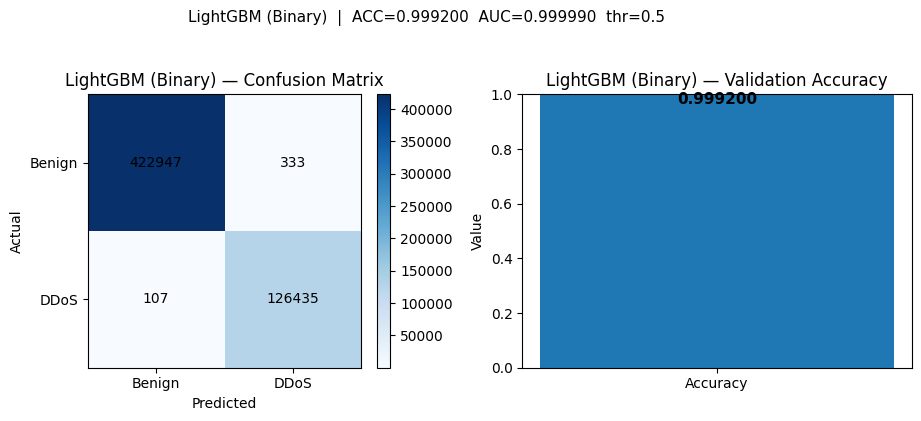


=== LightGBM (Binary) ===
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00    423280
        DDoS       1.00      1.00      1.00    126542

    accuracy                           1.00    549822
   macro avg       1.00      1.00      1.00    549822
weighted avg       1.00      1.00      1.00    549822

ROC-AUC: 0.9999899031971388


In [ ]:
# === Phase-1: LightGBM (Binary) — giữ nguyên logic (warm_start theo epoch) ===
EPOCHS = 3
ROUND_PER_EPOCH = 500

clf_bin = lgb.LGBMClassifier(
    objective='binary',
    learning_rate=0.05,
    num_leaves=128,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    class_weight='balanced',
    n_estimators=ROUND_PER_EPOCH,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=-1,
    warm_start=True
)

# --- Resume tùy chọn ---
# Nếu bạn đã có file .h5 trước đó: đặt path vào đây để tiếp tục tăng n_estimators
# ví dụ: r"D:\DACN\results\training\models\LGBM_Binary_Phase1-20251007-120000.h5"
RESUME_LGBM_BIN = r"D:\DACN\results\training\models\LGBM_Binary_Phase1-20251007-225015.h5"
if RESUME_LGBM_BIN and os.path.exists(RESUME_LGBM_BIN):
    clf_prev = load_model_h5_any(RESUME_LGBM_BIN)
    if isinstance(clf_prev, lgb.LGBMClassifier):
        clf_bin = clf_prev
        clf_bin.set_params(warm_start=True)
        print("[RESUME] Loaded previous LightGBM Binary model, will continue with more trees.")

for e in range(EPOCHS):
    clf_bin.n_estimators = getattr(clf_bin, "n_estimators", ROUND_PER_EPOCH) + ROUND_PER_EPOCH
    clf_bin.fit(
        X_res, y_res,
        eval_set=[(X_test_s, y_test)],
        eval_metric=['auc','binary_logloss'],
        callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)]
    )
    print(f"[✓] Epoch {e+1}/{EPOCHS} — best_iter: {clf_bin.best_iteration_}")

# Save
save_model_h5_any(
    clf_bin,
    name="LGBM_Binary_Phase1",
    extra={"feature_order": feature_candidates}
)

# Plot + Eval
yprob_lgb = clf_bin.predict_proba(X_test_s)[:,1]
show_cm_and_valacc(
    "LightGBM (Binary)", y_test, yprob_lgb, threshold=0.5,
    savepath=str(DIR_PLOTS / f"LGBM_Binary_Phase1-{_stamp()}.png")
)
_ = eval_binary(y_test, yprob_lgb, "LightGBM (Binary)")



# **Phase 1: XGBoost (Binary) + RandomForest (Binary) — Train/Resume + Lưu + Plot**

[INFO] xgboost version: 1.7.6
[RESUME] Continue XGBoost Binary with more trees
[0]	validation_0-auc:0.99464
[1]	validation_0-auc:0.99661
[2]	validation_0-auc:0.99728
[3]	validation_0-auc:0.99723
[4]	validation_0-auc:0.99826
[5]	validation_0-auc:0.99832
[6]	validation_0-auc:0.99830
[7]	validation_0-auc:0.99838
[8]	validation_0-auc:0.99843
[9]	validation_0-auc:0.99845
[10]	validation_0-auc:0.99905
[11]	validation_0-auc:0.99905
[12]	validation_0-auc:0.99905
[13]	validation_0-auc:0.99905
[14]	validation_0-auc:0.99905
[15]	validation_0-auc:0.99907
[16]	validation_0-auc:0.99906
[17]	validation_0-auc:0.99928
[18]	validation_0-auc:0.99929
[19]	validation_0-auc:0.99932
[20]	validation_0-auc:0.99933
[21]	validation_0-auc:0.99937
[22]	validation_0-auc:0.99937
[23]	validation_0-auc:0.99946
[24]	validation_0-auc:0.99950
[25]	validation_0-auc:0.99951
[26]	validation_0-auc:0.99954
[27]	validation_0-auc:0.99957
[28]	validation_0-auc:0.99961
[29]	validation_0-auc:0.99964
[30]	validation_0-auc:0.99966
[

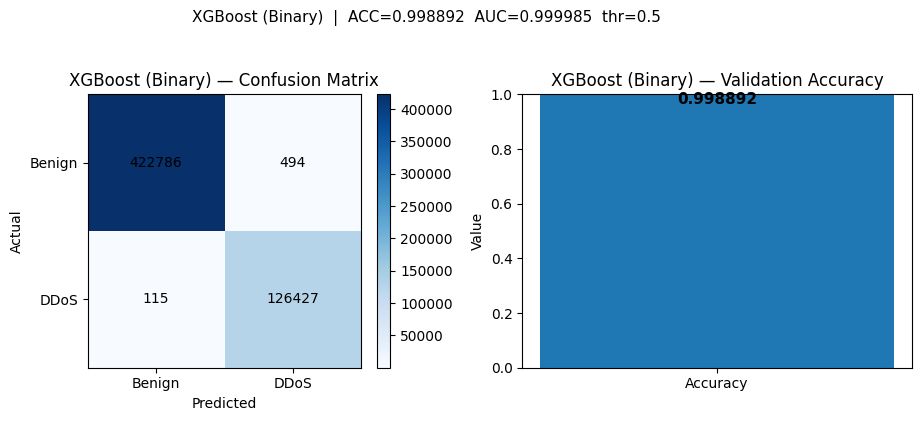


=== XGBoost (Binary) ===
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00    423280
        DDoS       1.00      1.00      1.00    126542

    accuracy                           1.00    549822
   macro avg       1.00      1.00      1.00    549822
weighted avg       1.00      1.00      1.00    549822

ROC-AUC: 0.9999845427781903
[RESUME] Continue RandomForest Binary with more trees
[SAVE] Pickled model-in-HDF5 -> D:\DACN\results\training\models\RF_Binary_Phase1-20251007-225620.h5


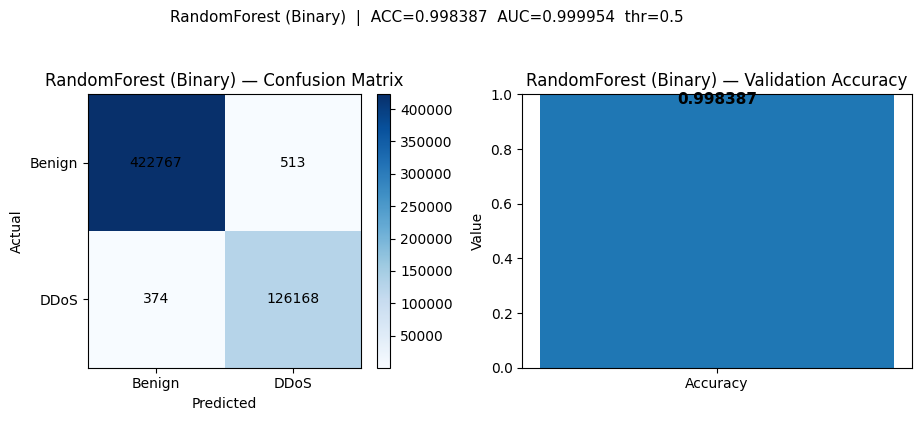


=== RandomForest (Binary) ===
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00    423280
        DDoS       1.00      1.00      1.00    126542

    accuracy                           1.00    549822
   macro avg       1.00      1.00      1.00    549822
weighted avg       1.00      1.00      1.00    549822

ROC-AUC: 0.9999535170350986


In [ ]:
# === Phase-1: XGBoost (Binary) + RandomForest (Binary) ===
import xgboost as xgb
from xgboost import XGBClassifier

MAX_TRAIN_SAMPLES_TREE = 1_000_000
rng = np.random.RandomState(42)
idx = rng.choice(len(X_res), size=min(MAX_TRAIN_SAMPLES_TREE, len(X_res)), replace=False)
X_tree = X_res[idx]; y_tree = y_res[idx]

print(f"[INFO] xgboost version: {xgb.__version__}")
xgb_bin = XGBClassifier(
    n_estimators=600, max_depth=8, learning_rate=0.05,
    subsample=0.9, colsample_bytree=0.9,
    reg_lambda=1.0, reg_alpha=0.0,
    tree_method="hist", n_jobs=-1, random_state=42,
    eval_metric="auc"
)

# --- Resume XGB (tùy chọn): nếu có .h5 trước đó thì load và tăng n_estimators ---
  # ví dụ: r"D:\DACN\results\training\models\XGBoost_Binary_Phase1-20251007-205801.h5"
RESUME_XGB_BIN = r"D:\DACN\results\training\models\XGBoost_Binary_Phase1-20251007-225402.h5"  # ví dụ path .h5 cũ
if RESUME_XGB_BIN and os.path.exists(RESUME_XGB_BIN):
    prev = load_model_h5_any(RESUME_XGB_BIN)
    if isinstance(prev, XGBClassifier):
        xgb_bin = prev
        # tăng thêm 200-400 cây:
        xgb_bin.set_params(n_estimators=xgb_bin.n_estimators + 200)
        print("[RESUME] Continue XGBoost Binary with more trees")

try:
    from xgboost import callback as xgb_cb
    early_cbs = [xgb_cb.EarlyStopping(rounds=50, metric_name="auc", maximize=True)]
    xgb_bin.fit(X_tree, y_tree, eval_set=[(X_test_s, y_test)], callbacks=early_cbs)
except TypeError:
    xgb_bin.fit(X_tree, y_tree, eval_set=[(X_test_s, y_test)], verbose=False)

yprob_xgb = xgb_bin.predict_proba(X_test_s)[:, 1]
save_model_h5_any(xgb_bin, "XGBoost_Binary_Phase1", extra={"feature_order": feature_candidates})
show_cm_and_valacc("XGBoost (Binary)", y_test, yprob_xgb, threshold=0.5,
                   savepath=str(DIR_PLOTS / f"XGB_Binary_Phase1-{_stamp()}.png"))
_ = eval_binary(y_test, yprob_xgb, "XGBoost (Binary)")

# ----- Random Forest (Binary) -----
rf_bin = RandomForestClassifier(
    n_estimators=400, max_depth=None, min_samples_leaf=2,
    class_weight="balanced_subsample", n_jobs=-1, random_state=42, warm_start=True
)

# Resume RF: tăng số cây nếu muốn
# ví dụ: r"D:\DACN\results\training\models\RF_Binary_Phase1-20251007-210259.h5"
RESUME_RF_BIN = r"D:\DACN\results\training\models\RF_Binary_Phase1-20251007-225620.h5"
if RESUME_RF_BIN and os.path.exists(RESUME_RF_BIN):
    prev = load_model_h5_any(RESUME_RF_BIN)
    if isinstance(prev, RandomForestClassifier):
        rf_bin = prev
        rf_bin.set_params(warm_start=True, n_estimators=rf_bin.n_estimators + 200)
        print("[RESUME] Continue RandomForest Binary with more trees")

rf_bin.fit(X_tree, y_tree)
yprob_rf = rf_bin.predict_proba(X_test_s)[:, 1]

save_model_h5_any(rf_bin, "RF_Binary_Phase1", extra={"feature_order": feature_candidates})
show_cm_and_valacc("RandomForest (Binary)", y_test, yprob_rf, threshold=0.5,
                   savepath=str(DIR_PLOTS / f"RF_Binary_Phase1-{_stamp()}.png"))
_ = eval_binary(y_test, yprob_rf, "RandomForest (Binary)")



# **Phase 2: Chuẩn bị dữ liệu đa lớp (AttackType)**

In [ ]:
# Lấy tất cả mẫu DDoS
df_attack = df_all[df_all['Label']=='DDoS'].copy()
X_attack = df_attack.reindex(columns=feature_candidates, fill_value=0.0).astype(np.float32)
X_attack_s = scaler.transform(X_attack)

# Mã hoá nhãn AttackType
y_attack_txt = df_attack['AttackType'].astype(str).values
le_attack = LabelEncoder()
y_attack = le_attack.fit_transform(y_attack_txt)
num_classes = len(le_attack.classes_)
joblib.dump(le_attack, ROOT_SAVE / "attack_label_encoder_union.pkl")
print("Classes:", list(le_attack.classes_))

# SMOTE multiclass
X_attack_res, y_attack_res = SMOTE(random_state=RANDOM_STATE).fit_resample(X_attack_s, y_attack)

# Train/test split
Xa_tr, Xa_te, ya_tr, ya_te = train_test_split(
    X_attack_res, y_attack_res, test_size=0.2, random_state=RANDOM_STATE, stratify=y_attack_res
)
Xa_tr = Xa_tr.astype(np.float16)
Xa_te = Xa_te.astype(np.float16)
print("Train:", Xa_tr.shape, "Test:", Xa_te.shape)

# Lưu để DL Phase-2 dùng
Xa_tr_dl = Xa_tr.astype(np.float32).reshape(-1, Xa_tr.shape[1], 1)
Xa_te_dl = Xa_te.astype(np.float32).reshape(-1, Xa_te.shape[1], 1)


Classes: ['Brute Force', 'DoS', 'LDAP', 'MSSQL', 'Other', 'PortScan', 'Syn', 'UDP', 'Web Attack']
Train: (2507767, 156) Test: (626942, 156)



# **Phase 2: LightGBM (Multiclass) — Train + Lưu + Plot)**

[SAVE] Pickled model-in-HDF5 -> D:\DACN\results\training\models\LGBM_Multiclass_Phase2-20251007-230143.h5
              precision    recall  f1-score   support

 Brute Force       1.00      1.00      1.00      1869
         DoS       1.00      1.00      1.00     38547
        LDAP       0.91      0.99      0.95       418
       MSSQL       0.95      0.97      0.96      1719
       Other       1.00      1.00      1.00     69759
    PortScan       0.97      1.00      0.98       385
         Syn       1.00      1.00      1.00      9786
         UDP       0.99      0.98      0.99      3622
  Web Attack       1.00      1.00      1.00       437

    accuracy                           1.00    126542
   macro avg       0.98      0.99      0.99    126542
weighted avg       1.00      1.00      1.00    126542

[Saved] D:\DACN\results\training\plots\LGBM_Multiclass_Phase2-20251007-230150.png


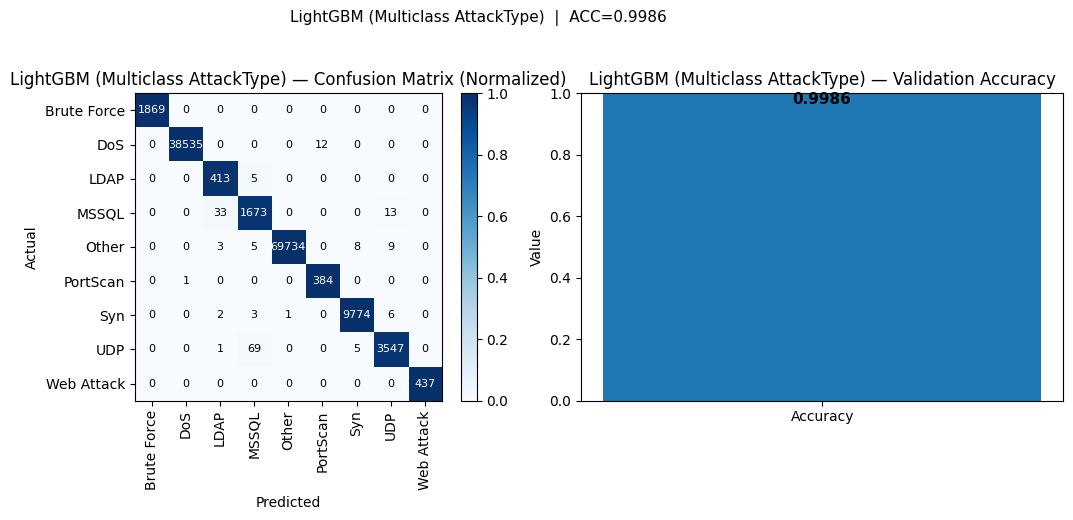

In [12]:
clf_multi = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=num_classes,
    n_estimators=1600,
    learning_rate=0.05,
    num_leaves=128,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

clf_multi.fit(
    Xa_tr, ya_tr,
    eval_set=[(Xa_te, ya_te)],
    eval_metric=['multi_logloss'],
    callbacks=[lgb.early_stopping(stopping_rounds=80, verbose=False)]
)

save_model_h5_any(
    clf_multi,
    name="LGBM_Multiclass_Phase2",
    extra={"feature_order": feature_candidates, "classes": list(le_attack.classes_)}
)

# Đánh giá trên phần DDoS của test từ Phase-1 (đúng logic gốc)
test_mask_ddos = (y_test == 1)
X_attack_test = X_test_s[test_mask_ddos]
y_attack_test_txt = df_all.iloc[X_test_raw.index][test_mask_ddos]['AttackType'].astype(str).values

y_attack_test = []
for t in y_attack_test_txt:
    if t in le_attack.classes_:
        y_attack_test.append(le_attack.transform([t])[0])
    else:
        if "Other" in le_attack.classes_:
            y_attack_test.append(le_attack.transform(["Other"])[0])
        else:
            y_attack_test.append(-1)
y_attack_test = np.array([v for v in y_attack_test if v >= 0])

y_attack_pred = clf_multi.predict(X_attack_test[:len(y_attack_test)])

print(classification_report(y_attack_test, y_attack_pred, target_names=le_attack.classes_))
show_cm_and_valacc_multiclass(
    "LightGBM (Multiclass AttackType)",
    y_attack_test, y_attack_pred, labels=le_attack.classes_,
    savepath=str(DIR_PLOTS / f"LGBM_Multiclass_Phase2-{_stamp()}.png")
)



# **Phase 2: XGBoost (Multiclass) — Train/Resume + Lưu + Plot**


=== Classification Report (Phase 2 — XGBoost) ===
              precision    recall  f1-score   support

 Brute Force       1.00      1.00      1.00     69660
         DoS       1.00      1.00      1.00     69660
        LDAP       0.98      0.99      0.98     69660
       MSSQL       0.96      0.97      0.97     69661
       Other       1.00      1.00      1.00     69660
    PortScan       1.00      1.00      1.00     69660
         Syn       1.00      1.00      1.00     69661
         UDP       1.00      0.98      0.99     69660
  Web Attack       1.00      1.00      1.00     69660

    accuracy                           0.99    626942
   macro avg       0.99      0.99      0.99    626942
weighted avg       0.99      0.99      0.99    626942

[SAVE] Pickled model-in-HDF5 -> D:\DACN\results\training\models\XGBoost_Multiclass_Phase2-20251007-231859.h5
[Saved] D:\DACN\results\training\plots\XGB_Multiclass_Phase2-20251007-231859.png


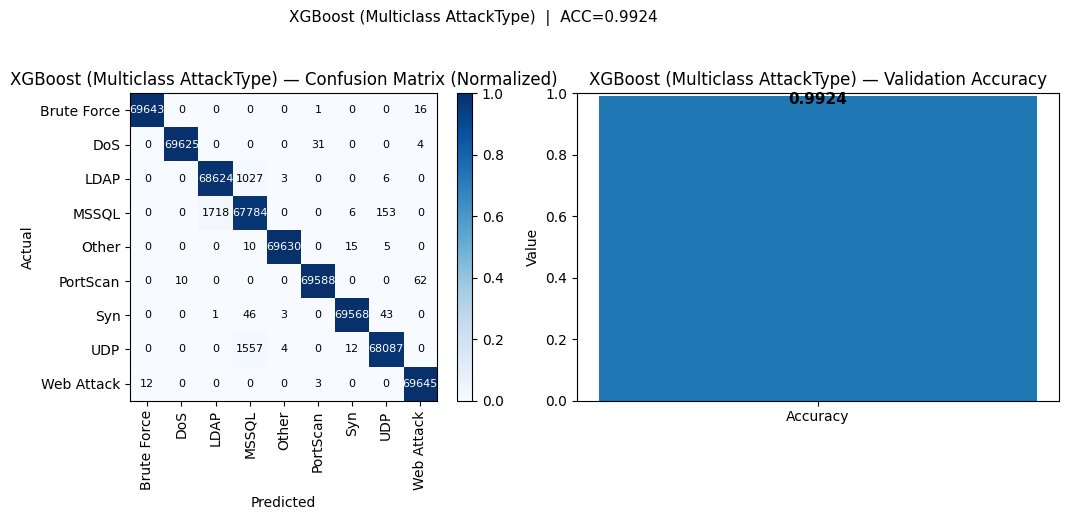

In [13]:
from xgboost import XGBClassifier

xgb_multi = XGBClassifier(
    objective="multi:softprob",
    num_class=num_classes,
    n_estimators=500,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    tree_method="hist",
    predictor="auto",
    random_state=RANDOM_STATE,
    eval_metric="mlogloss"
)

# Resume (tuỳ chọn)
# ví dụ: r"D:\DACN\results\training\models\XGBoost_Binary_Phase1-20251007-205801.h5"
RESUME_XGB_MULTI = None
if RESUME_XGB_MULTI and os.path.exists(RESUME_XGB_MULTI):
    prev = load_model_h5_any(RESUME_XGB_MULTI)
    if isinstance(prev, XGBClassifier):
        xgb_multi = prev
        xgb_multi.set_params(n_estimators=xgb_multi.n_estimators + 200)
        print("[RESUME] Continue XGB Multiclass with more trees")

xgb_multi.fit(Xa_tr, ya_tr, eval_set=[(Xa_te, ya_te)], verbose=False)
ya_pred = xgb_multi.predict(Xa_te)

print("\n=== Classification Report (Phase 2 — XGBoost) ===")
print(classification_report(ya_te, ya_pred, target_names=le_attack.classes_))

save_model_h5_any(
    xgb_multi,
    name="XGBoost_Multiclass_Phase2",
    extra={"feature_order": feature_candidates, "classes": list(le_attack.classes_)}
)

show_cm_and_valacc_multiclass(
    "XGBoost (Multiclass AttackType)",
    ya_te, ya_pred, labels=le_attack.classes_,
    savepath=str(DIR_PLOTS / f"XGB_Multiclass_Phase2-{_stamp()}.png")
)



# **Phase 2: RandomForest (Multiclass) — Train/Resume + Lưu + Plot**

[RandomForest] Training...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   58.4s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  4.9min
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:  8.3min finished


[RandomForest] Done.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    4.5s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    7.3s finished



=== Classification Report (RandomForest — Multiclass) ===
              precision    recall  f1-score   support

 Brute Force       1.00      0.99      0.99     69660
         DoS       1.00      1.00      1.00     69660
        LDAP       0.98      0.99      0.98     69660
       MSSQL       0.97      0.98      0.97     69661
       Other       1.00      1.00      1.00     69660
    PortScan       1.00      1.00      1.00     69660
         Syn       1.00      1.00      1.00     69661
         UDP       1.00      0.98      0.99     69660
  Web Attack       0.98      1.00      0.99     69660

    accuracy                           0.99    626942
   macro avg       0.99      0.99      0.99    626942
weighted avg       0.99      0.99      0.99    626942

[SAVE] Pickled model-in-HDF5 -> D:\DACN\results\training\models\RF_Multiclass_Phase2-20251007-232729.h5


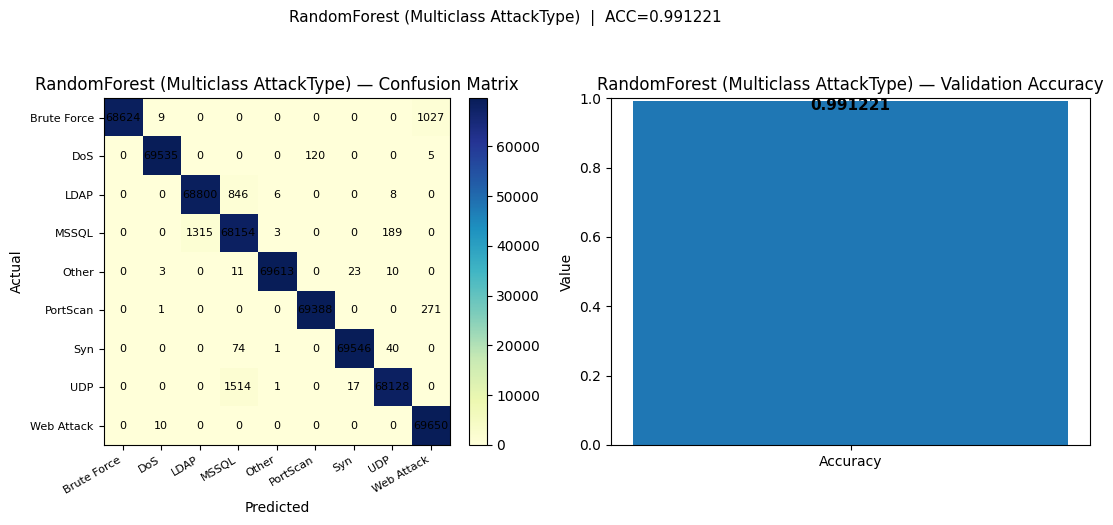

RandomForest (Multiclass AttackType) — Accuracy: 0.991221



In [14]:
rf_multi = RandomForestClassifier(
    n_estimators=300,
    max_depth=14,
    min_samples_split=4,
    min_samples_leaf=2,
    max_features="sqrt",
    bootstrap=True,
    class_weight="balanced_subsample",
    n_jobs=8,
    random_state=RANDOM_STATE,
    verbose=1,
    warm_start=True
)

# ví dụ: r"D:\DACN\results\training\models\XGBoost_Binary_Phase1-20251007-205801.h5"
RESUME_RF_MULTI = None
if RESUME_RF_MULTI and os.path.exists(RESUME_RF_MULTI):
    prev = load_model_h5_any(RESUME_RF_MULTI)
    if isinstance(prev, RandomForestClassifier):
        rf_multi = prev
        rf_multi.set_params(warm_start=True, n_estimators=rf_multi.n_estimators + 100)
        print("[RESUME] Continue RF Multiclass with more trees")

print("[RandomForest] Training...")
rf_multi.fit(Xa_tr, ya_tr)
print("[RandomForest] Done.")

ya_pred_rf = rf_multi.predict(Xa_te)
print("\n=== Classification Report (RandomForest — Multiclass) ===")
print(classification_report(ya_te, ya_pred_rf, target_names=le_attack.classes_))

save_model_h5_any(
    rf_multi,
    name="RF_Multiclass_Phase2",
    extra={"feature_order": feature_candidates, "classes": list(le_attack.classes_)}
)

# plot
def show_cm_multiclass(model_name, y_true, y_pred, labels, savepath=None):
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))
    fig, axes = plt.subplots(1, 2, figsize=(12,5))
    im = axes[0].imshow(cm, cmap="YlGnBu")
    for (i,j),v in np.ndenumerate(cm):
        axes[0].text(j, i, str(v), ha="center", va="center", fontsize=8)
    axes[0].set_xticks(range(len(labels)))
    axes[0].set_xticklabels(labels, rotation=30, ha="right", fontsize=8)
    axes[0].set_yticks(range(len(labels)))
    axes[0].set_yticklabels(labels, fontsize=8)
    axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("Actual")
    axes[0].set_title(f"{model_name} — Confusion Matrix")
    fig.colorbar(im, ax=axes[0], fraction=0.046, pad=0.04)

    axes[1].bar([0], [acc], width=0.5)
    axes[1].set_ylim(0, 1.0)
    axes[1].set_xticks([0]); axes[1].set_xticklabels(["Accuracy"])
    axes[1].set_ylabel("Value")
    axes[1].set_title(f"{model_name} — Validation Accuracy")
    axes[1].text(0, min(acc+0.03, 0.98), f"{acc:.6f}", ha="center", va="center", fontsize=11, fontweight="bold")

    plt.suptitle(f"{model_name}  |  ACC={acc:.6f}", y=1.04, fontsize=11)
    plt.tight_layout()
    if savepath: plt.savefig(savepath, dpi=140, bbox_inches="tight")
    plt.show()
    print(f"{model_name} — Accuracy: {acc:.6f}\n")

show_cm_multiclass(
    "RandomForest (Multiclass AttackType)", ya_te, ya_pred_rf, list(le_attack.classes_),
    savepath=str(DIR_PLOTS / f"RF_Multiclass_Phase2-{_stamp()}.png")
)



# **Phase 1: Deep Learning (Binary — LSTM/GRU/CNN) — Train/Resume + Lưu + Plot**


=== LSTM (Binary) ===
              precision    recall  f1-score   support

      Benign       0.92      0.98      0.95    423280
        DDoS       0.91      0.71      0.80    126542

    accuracy                           0.92    549822
   macro avg       0.92      0.85      0.87    549822
weighted avg       0.92      0.92      0.91    549822

ROC-AUC: 0.824329096768781
[SAVE] Pickled model-in-HDF5 -> D:\DACN\results\training\models\LSTM_Binary_Phase1-20251008-005017.h5


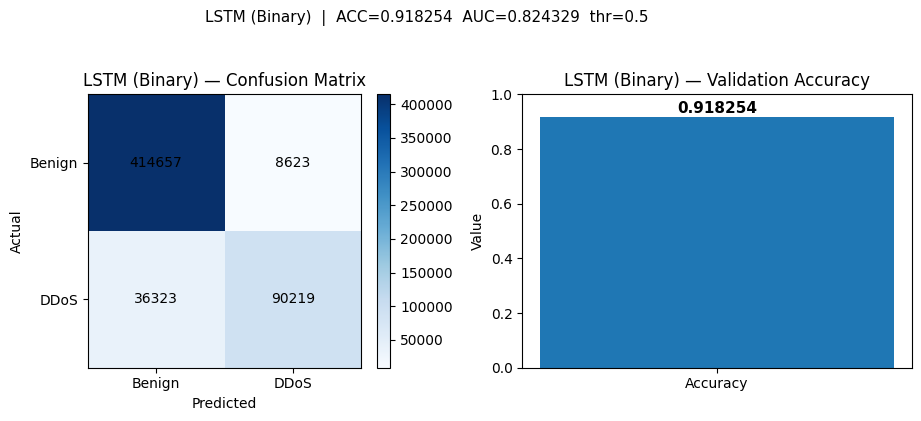


=== GRU (Binary) ===
              precision    recall  f1-score   support

      Benign       0.99      0.99      0.99    423280
        DDoS       0.98      0.97      0.98    126542

    accuracy                           0.99    549822
   macro avg       0.98      0.98      0.98    549822
weighted avg       0.99      0.99      0.99    549822

ROC-AUC: 0.9989221962874485
[SAVE] Pickled model-in-HDF5 -> D:\DACN\results\training\models\GRU_Binary_Phase1-20251008-074809.h5


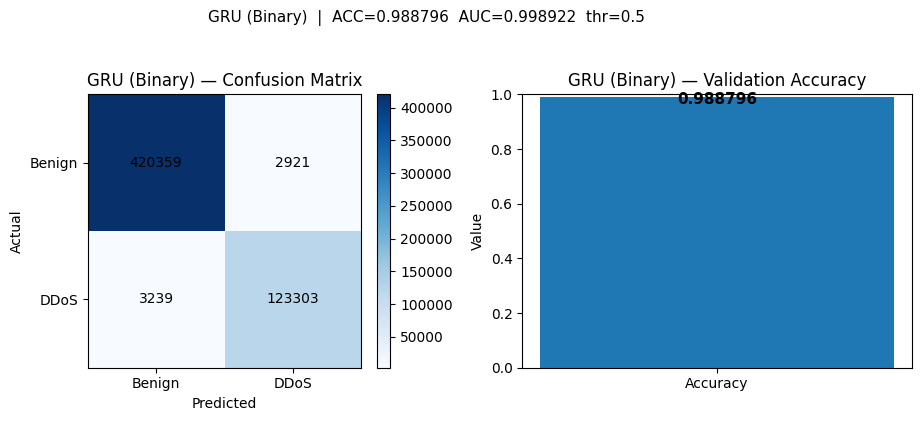


=== 1D-CNN (Binary) ===
              precision    recall  f1-score   support

      Benign       0.96      0.94      0.95    423280
        DDoS       0.81      0.88      0.84    126542

    accuracy                           0.92    549822
   macro avg       0.88      0.91      0.90    549822
weighted avg       0.93      0.92      0.93    549822

ROC-AUC: 0.9657748358901926
[SAVE] Pickled model-in-HDF5 -> D:\DACN\results\training\models\CNN1D_Binary_Phase1-20251008-075531.h5


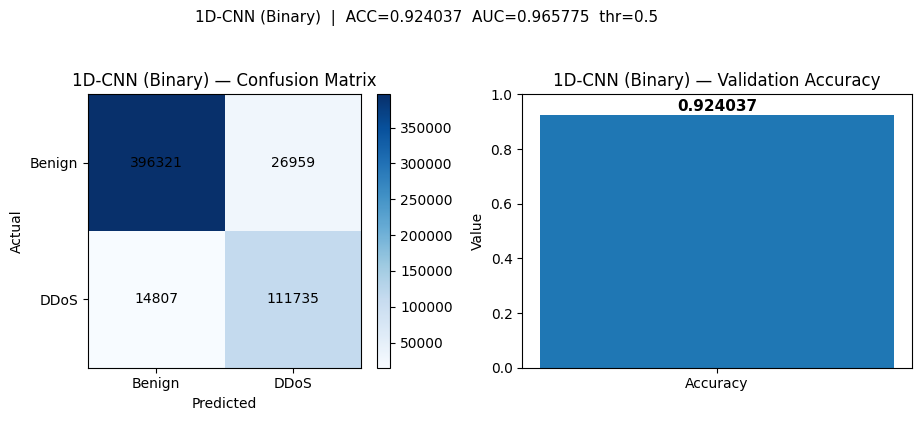

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks # type: ignore

EPOCHS_DL = 20
BATCH = 2048

cb = [
    callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor="val_auc", mode="max"),
    callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-5, monitor="val_auc", mode="max"),
    StopOnTinyChange(monitor="val_auc", min_delta=1e-4),
]

def compile_binary(model):
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss="binary_crossentropy",
                  metrics=[tf.keras.metrics.AUC(name="auc")])
    return model

# ----- LSTM -----
if 'lstm' not in globals():
    lstm = models.Sequential([
        layers.Input(shape=(X_train_dl.shape[1], 1)),
        layers.LSTM(64, return_sequences=True),
        layers.LSTM(32),
        layers.Dense(16, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
compile_binary(lstm)
lstm.fit(
    X_train_dl, y_train_dl,
    epochs=EPOCHS_DL, batch_size=BATCH,
    validation_data=(X_test_dl, y_test_dl),
    callbacks=cb,
    verbose=1                                      # <<< BẬT LOG CHI TIẾT
)
yprob_lstm = lstm.predict(X_test_dl, batch_size=BATCH, verbose=0).ravel()
_ = eval_binary(y_test, yprob_lstm, "LSTM (Binary)")
save_model_h5_any(lstm, "LSTM_Binary_Phase1")
show_cm_and_valacc("LSTM (Binary)", y_test, yprob_lstm, threshold=0.5,
                   savepath=str(DIR_PLOTS / f"LSTM_Binary_Phase1-{_stamp()}.png"))

# ----- GRU -----
if 'gru' not in globals():
    gru = models.Sequential([
        layers.Input(shape=(X_train_dl.shape[1], 1)),
        layers.GRU(64, return_sequences=True),
        layers.GRU(32),
        layers.Dense(16, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
compile_binary(gru)
gru.fit(X_train_dl, y_train_dl, epochs=EPOCHS_DL, batch_size=BATCH,
        validation_data=(X_test_dl, y_test_dl), callbacks=cb, verbose=0)
yprob_gru = gru.predict(X_test_dl, batch_size=BATCH, verbose=0).ravel()
_ = eval_binary(y_test, yprob_gru, "GRU (Binary)")
save_model_h5_any(gru, "GRU_Binary_Phase1")
show_cm_and_valacc("GRU (Binary)", y_test, yprob_gru, threshold=0.5,
                   savepath=str(DIR_PLOTS / f"GRU_Binary_Phase1-{_stamp()}.png"))

# ----- 1D-CNN -----
if 'cnn' not in globals():
    cnn = models.Sequential([
        layers.Input(shape=(X_train_dl.shape[1], 1)),
        layers.Conv1D(64, kernel_size=5, activation="relu"),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(64, kernel_size=3, activation="relu"),
        layers.GlobalAveragePooling1D(),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
compile_binary(cnn)
cnn.fit(X_train_dl, y_train_dl, epochs=EPOCHS_DL, batch_size=BATCH,
        validation_data=(X_test_dl, y_test_dl), callbacks=cb, verbose=0)
yprob_cnn = cnn.predict(X_test_dl, batch_size=BATCH, verbose=0).ravel()
_ = eval_binary(y_test, yprob_cnn, "1D-CNN (Binary)")
save_model_h5_any(cnn, "CNN1D_Binary_Phase1")
show_cm_and_valacc("1D-CNN (Binary)", y_test, yprob_cnn, threshold=0.5,
                   savepath=str(DIR_PLOTS / f"CNN1D_Binary_Phase1-{_stamp()}.png"))


In [ ]:
#mới thêm có thể xóa (thêm để test độ hiệu quả)
# %% DL (Binary) — nâng chất & tối ưu ngưỡng cho LSTM/GRU/CNN
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks  # type: ignore
import numpy as np
from sklearn.metrics import precision_recall_curve, classification_report

# EPOCHS_DL = 25         # 20 -> 25 (vẫn early stop)
# BATCH = 2048
EPOCHS_DL = 3
BATCH = 4096

# ----- Callbacks giữ nguyên -----
cb = [
    callbacks.EarlyStopping(patience=4, restore_best_weights=True, monitor="val_auc", mode="max"),
    callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-5, monitor="val_auc", mode="max"),
    StopOnTinyChange(monitor="val_auc", min_delta=1e-4),
]

# ===== Focal loss & tối ưu ngưỡng =====
def focal_binary_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        eps = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, eps, 1.0-eps)
        pt = tf.where(tf.equal(y_true,1), y_pred, 1-y_pred)
        w  = tf.where(tf.equal(y_true,1), alpha, 1-alpha)
        return -tf.reduce_mean(w * tf.pow(1-pt, gamma) * tf.math.log(pt))
    return loss

def find_best_threshold(y_true, y_prob, min_recall=None):
    p, r, thr = precision_recall_curve(y_true, y_prob)
    f1 = 2*p[:-1]*r[:-1]/(p[:-1]+r[:-1] + 1e-9)
    if min_recall is not None:
        mask = r[:-1] >= float(min_recall)
        if mask.any():
            idx = np.flatnonzero(mask)[f1[mask].argmax()]
        else:
            idx = f1.argmax()
    else:
        idx = f1.argmax()
    return float(thr[idx]), float(p[idx]), float(r[idx]), float(f1[idx])

# ===== compile tiện dụng (focal + jit) =====
def compile_binary(model, use_focal=True, lr=1e-3):
    if use_focal:
        loss_fn = focal_binary_loss(gamma=2.0, alpha=0.25)
    else:
        loss_fn = "binary_crossentropy"
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss=loss_fn,
        metrics=[tf.keras.metrics.AUC(name="auc")],
        jit_compile=True  # tăng tốc TF2.16
    )
    return model

# =========================
# LSTM — nâng cấp nhẹ
# =========================
if 'lstm' not in globals():
    lstm = models.Sequential([
        layers.Input(shape=(X_train_dl.shape[1], 1)),
        layers.Bidirectional(layers.LSTM(128, return_sequences=True,
                                         dropout=0.2, recurrent_dropout=0.2)),
        layers.Bidirectional(layers.LSTM(64, return_sequences=False,
                                         dropout=0.2, recurrent_dropout=0.2)),
        layers.Dense(32, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid")
    ])
compile_binary(lstm, use_focal=True, lr=1e-3)
lstm.fit(X_train_dl, y_train_dl, epochs=EPOCHS_DL, batch_size=BATCH,
         validation_data=(X_test_dl, y_test_dl), callbacks=cb, verbose=1)

yprob_lstm = lstm.predict(X_test_dl, batch_size=BATCH, verbose=0).ravel()
best_thr_lstm, bp, br, bf1 = find_best_threshold(y_test, yprob_lstm, min_recall=0.85)  # đặt None nếu chỉ tối đa F1
print(f"[LSTM] Best thr={best_thr_lstm:.4f} | P={bp:.3f} R={br:.3f} F1={bf1:.3f}")
print(classification_report(y_test, (yprob_lstm >= best_thr_lstm).astype(int), target_names=['Benign','DDoS']))

# log vào bảng tổng hợp Phase-1 với ngưỡng tối ưu
_ = eval_binary(y_test, yprob_lstm, f"LSTM (Binary, thr@{best_thr_lstm:.3f})", threshold=best_thr_lstm)
save_model_h5_any(lstm, "LSTM_Binary_Phase1", extra={"best_threshold": best_thr_lstm})
show_cm_and_valacc("LSTM (Binary)", y_test, yprob_lstm, threshold=best_thr_lstm,
                   savepath=str(DIR_PLOTS / f"LSTM_Binary_Phase1-{_stamp()}.png"))

# =========================
# GRU — giữ kiến trúc, thêm focal + jit + chọn ngưỡng
# =========================
if 'gru' not in globals():
    gru = models.Sequential([
        layers.Input(shape=(X_train_dl.shape[1], 1)),
        layers.GRU(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
        layers.GRU(64,  return_sequences=False, dropout=0.2, recurrent_dropout=0.2),
        layers.Dense(32, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid")
    ])
compile_binary(gru, use_focal=True, lr=1e-3)
gru.fit(X_train_dl, y_train_dl, epochs=EPOCHS_DL, batch_size=BATCH,
        validation_data=(X_test_dl, y_test_dl), callbacks=cb, verbose=1)

yprob_gru = gru.predict(X_test_dl, batch_size=BATCH, verbose=0).ravel()
best_thr_gru, bp, br, bf1 = find_best_threshold(y_test, yprob_gru, min_recall=0.85)
print(f"[GRU] Best thr={best_thr_gru:.4f} | P={bp:.3f} R={br:.3f} F1={bf1:.3f}")
_ = eval_binary(y_test, yprob_gru, f"GRU (Binary, thr@{best_thr_gru:.3f})", threshold=best_thr_gru)
save_model_h5_any(gru, "GRU_Binary_Phase1", extra={"best_threshold": best_thr_gru})
show_cm_and_valacc("GRU (Binary)", y_test, yprob_gru, threshold=best_thr_gru,
                   savepath=str(DIR_PLOTS / f"GRU_Binary_Phase1-{_stamp()}.png"))

# =========================
# 1D-CNN — giữ kiến trúc, thêm focal + jit + chọn ngưỡng
# =========================
if 'cnn' not in globals():
    cnn = models.Sequential([
        layers.Input(shape=(X_train_dl.shape[1], 1)),
        layers.Conv1D(64, kernel_size=5, activation="relu"),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(64, kernel_size=3, activation="relu"),
        layers.GlobalAveragePooling1D(),
        layers.Dense(32, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid")
    ])
compile_binary(cnn, use_focal=True, lr=1e-3)
cnn.fit(X_train_dl, y_train_dl, epochs=EPOCHS_DL, batch_size=BATCH,
        validation_data=(X_test_dl, y_test_dl), callbacks=cb, verbose=1)

yprob_cnn = cnn.predict(X_test_dl, batch_size=BATCH, verbose=0).ravel()
best_thr_cnn, bp, br, bf1 = find_best_threshold(y_test, yprob_cnn, min_recall=0.85)
print(f"[CNN] Best thr={best_thr_cnn:.4f} | P={bp:.3f} R={br:.3f} F1={bf1:.3f}")
_ = eval_binary(y_test, yprob_cnn, f"1D-CNN (Binary, thr@{best_thr_cnn:.3f})", threshold=best_thr_cnn)
save_model_h5_any(cnn, "CNN1D_Binary_Phase1", extra={"best_threshold": best_thr_cnn})
show_cm_and_valacc("1D-CNN (Binary)", y_test, yprob_cnn, threshold=best_thr_cnn,
                   savepath=str(DIR_PLOTS / f"CNN1D_Binary_Phase1-{_stamp()}.png"))


Epoch 1/3


In [ ]:
#Phase 2 ở cell trên (thử nghiệm)
# %% DL (Multiclass) — LSTM/GRU/CNN cho AttackType (Phase-2)
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks  # type: ignore
from sklearn.metrics import classification_report, accuracy_score

EPOCHS_DL2 = 5
BATCH2 = 4096
num_classes = len(le_attack.classes_)
input_len = Xa_tr_dl.shape[1]

cb_mc = [
    callbacks.EarlyStopping(patience=4, restore_best_weights=True, monitor="val_accuracy"),
    callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-5),
    StopOnTinyChange(monitor="val_accuracy", min_delta=1e-4),
]

# ---------- LSTM (Multiclass) ----------
if 'lstm_mc' not in globals():
    lstm_mc = models.Sequential([
        layers.Input(shape=(input_len, 1)),
        layers.Bidirectional(layers.LSTM(128, return_sequences=True,
                                         dropout=0.2, recurrent_dropout=0.2)),
        layers.Bidirectional(layers.LSTM(64, return_sequences=False,
                                         dropout=0.2, recurrent_dropout=0.2)),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation="softmax")
    ])
lstm_mc.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"],
                jit_compile=True)
lstm_mc.fit(Xa_tr_dl, ya_tr, epochs=EPOCHS_DL2, batch_size=BATCH2,
            validation_data=(Xa_te_dl, ya_te), callbacks=cb_mc, verbose=1)
y_pred_lstm_mc = tf.argmax(lstm_mc.predict(Xa_te_dl, batch_size=BATCH2, verbose=0), axis=1).numpy()
print("\nLSTM (Multiclass) — ACC:", accuracy_score(ya_te, y_pred_lstm_mc))
print(classification_report(ya_te, y_pred_lstm_mc, target_names=le_attack.classes_))
save_model_h5_any(lstm_mc, "LSTM_Multiclass_Phase2",
                  extra={"classes": list(le_attack.classes_), "feature_order": feature_candidates})
show_cm_and_valacc_multiclass("LSTM (Multiclass AttackType)",
                              ya_te, y_pred_lstm_mc, labels=le_attack.classes_,
                              savepath=str(DIR_PLOTS / f"LSTM_Multiclass_Phase2-{_stamp()}.png"))

# ---------- GRU (Multiclass) ----------
if 'gru_mc' not in globals():
    gru_mc = models.Sequential([
        layers.Input(shape=(input_len, 1)),
        layers.GRU(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
        layers.GRU(64,  return_sequences=False, dropout=0.2, recurrent_dropout=0.2),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation="softmax")
    ])
gru_mc.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
               loss="sparse_categorical_crossentropy",
               metrics=["accuracy"],
               jit_compile=True)
gru_mc.fit(Xa_tr_dl, ya_tr, epochs=EPOCHS_DL2, batch_size=BATCH2,
           validation_data=(Xa_te_dl, ya_te), callbacks=cb_mc, verbose=1)
y_pred_gru_mc = tf.argmax(gru_mc.predict(Xa_te_dl, batch_size=BATCH2, verbose=0), axis=1).numpy()
print("\nGRU (Multiclass) — ACC:", accuracy_score(ya_te, y_pred_gru_mc))
print(classification_report(ya_te, y_pred_gru_mc, target_names=le_attack.classes_))
save_model_h5_any(gru_mc, "GRU_Multiclass_Phase2",
                  extra={"classes": list(le_attack.classes_), "feature_order": feature_candidates})
show_cm_and_valacc_multiclass("GRU (Multiclass AttackType)",
                              ya_te, y_pred_gru_mc, labels=le_attack.classes_,
                              savepath=str(DIR_PLOTS / f"GRU_Multiclass_Phase2-{_stamp()}.png"))

# ---------- 1D-CNN (Multiclass) ----------
if 'cnn_mc' not in globals():
    cnn_mc = models.Sequential([
        layers.Input(shape=(input_len, 1)),
        layers.Conv1D(64, kernel_size=5, activation="relu"),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(64, kernel_size=3, activation="relu"),
        layers.GlobalAveragePooling1D(),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation="softmax")
    ])
cnn_mc.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
               loss="sparse_categorical_crossentropy",
               metrics=["accuracy"],
               jit_compile=True)
cnn_mc.fit(Xa_tr_dl, ya_tr, epochs=EPOCHS_DL2, batch_size=BATCH2,
           validation_data=(Xa_te_dl, ya_te), callbacks=cb_mc, verbose=1)
y_pred_cnn_mc = tf.argmax(cnn_mc.predict(Xa_te_dl, batch_size=BATCH2, verbose=0), axis=1).numpy()
print("\n1D-CNN (Multiclass) — ACC:", accuracy_score(ya_te, y_pred_cnn_mc))
print(classification_report(ya_te, y_pred_cnn_mc, target_names=le_attack.classes_))
save_model_h5_any(cnn_mc, "CNN1D_Multiclass_Phase2",
                  extra={"classes": list(le_attack.classes_), "feature_order": feature_candidates})
show_cm_and_valacc_multiclass("1D-CNN (Multiclass AttackType)",
                              ya_te, y_pred_cnn_mc, labels=le_attack.classes_,
                              savepath=str(DIR_PLOTS / f"CNN1D_Multiclass_Phase2-{_stamp()}.png"))


# **TEST PHASE 1**

In [11]:
# %% Phase-1 Trees — KHÔNG SMOTE: dùng scale_pos_weight / is_unbalance
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
import numpy as np

neg = int((y_train==0).sum()); pos = int((y_train==1).sum())
spw = max(1.0, neg / max(1, pos))
print("scale_pos_weight =", spw)

# XGBoost (Binary)
xgb_bin = XGBClassifier(
    n_estimators=600, max_depth=8, learning_rate=0.05,
    subsample=0.9, colsample_bytree=0.9,
    tree_method="hist", max_bin=256,
    reg_lambda=1.0, random_state=42, n_jobs=-1,
    eval_metric="auc",
    scale_pos_weight=spw
)
xgb_bin.fit(X_train_s, y_train, eval_set=[(X_test_s, y_test)], verbose=False)
yprob_xgb = xgb_bin.predict_proba(X_test_s)[:,1]
_ = eval_binary(y_test, yprob_xgb, "XGBoost (Binary)")

# LightGBM (Binary)
lgb_bin = lgb.LGBMClassifier(
    objective='binary', learning_rate=0.05, num_leaves=96,
    subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
    n_estimators=1200, n_jobs=-1, random_state=42,
    is_unbalance=True  # hoặc scale_pos_weight=spw
)
lgb_bin.fit(X_train_s, y_train, eval_set=[(X_test_s, y_test)],
            eval_metric=['auc','binary_logloss'],
            callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)])
yprob_lgb = lgb_bin.predict_proba(X_test_s)[:,1]
_ = eval_binary(y_test, yprob_lgb, "LightGBM (Binary)")

# RandomForest (Binary) — cap mẫu để nhanh
MAX_TRAIN_SAMPLES_TREE = 800_000
idx = np.random.RandomState(42).choice(len(X_train_s), size=min(MAX_TRAIN_SAMPLES_TREE, len(X_train_s)), replace=False)
# DÙNG TOÀN BỘ
X_tree, y_tree = X_train_s, y_train

rf_bin = RandomForestClassifier(
    n_estimators=350, max_depth=None, min_samples_leaf=2,
    max_features="sqrt", class_weight="balanced_subsample",
    n_jobs=-1, random_state=42
)
rf_bin.fit(X_tree, y_tree)

yprob_rf = rf_bin.predict_proba(X_test_s)[:,1]
_ = eval_binary(y_test, yprob_rf, "RandomForest (Binary)")


scale_pos_weight = 3.344982979925598

=== XGBoost (Binary) ===
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00    423280
        DDoS       1.00      1.00      1.00    126542

    accuracy                           1.00    549822
   macro avg       1.00      1.00      1.00    549822
weighted avg       1.00      1.00      1.00    549822

ROC-AUC: 0.9999899879389496
[LightGBM] [Info] Number of positive: 506167, number of negative: 1693120
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.196314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21830
[LightGBM] [Info] Number of data points in the train set: 2199287, number of used features: 146
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.230150 -> initscore=-1.207462
[LightGBM] [Info] Start training from score -1.207462

=== LightGBM (Bi

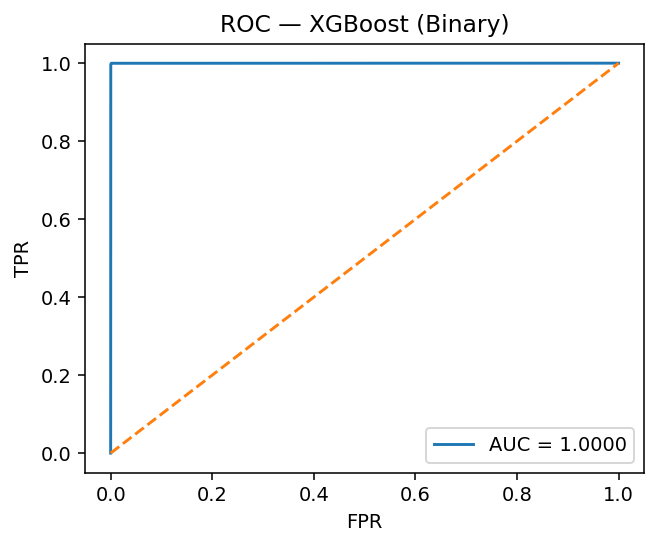

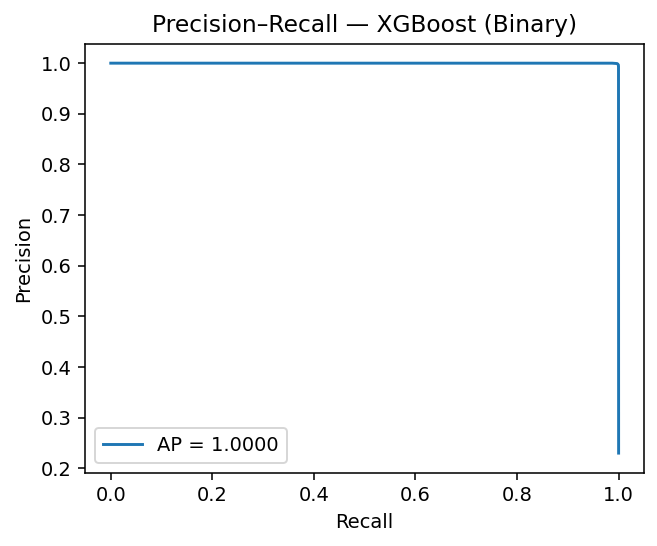


=== XGBoost (Binary) — Summary ===
ROC AUC = 0.999990 | AP = 0.999975
Best-F1 threshold = 0.730180 | F1=0.998234 | P=0.998269 | R=0.998198

--- Metrics @ th=0.50 ---
Accuracy=0.999009 | F1=0.997850 | Precision=0.996282 | Recall=0.999423
Classification Report:
              precision    recall  f1-score   support

           0     0.9998    0.9989    0.9994    423280
           1     0.9963    0.9994    0.9978    126542

    accuracy                         0.9990    549822
   macro avg     0.9981    0.9992    0.9986    549822
weighted avg     0.9990    0.9990    0.9990    549822



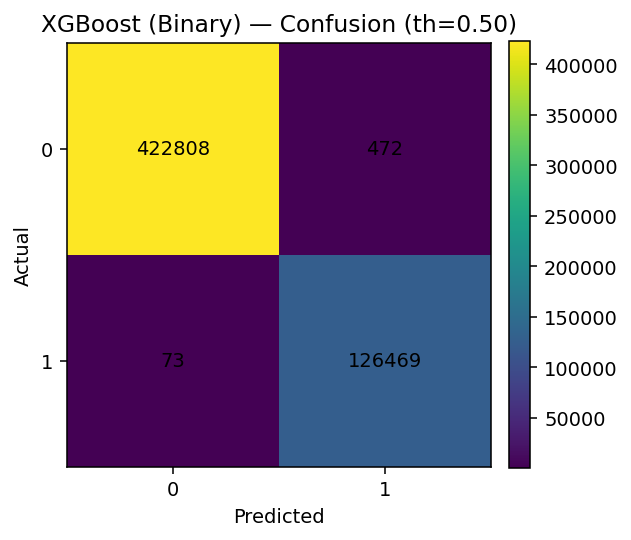


--- Metrics @ th=F1*=0.7302 ---
Accuracy=0.999187 | F1=0.998234 | Precision=0.998269 | Recall=0.998198
Classification Report:
              precision    recall  f1-score   support

           0     0.9995    0.9995    0.9995    423280
           1     0.9983    0.9982    0.9982    126542

    accuracy                         0.9992    549822
   macro avg     0.9989    0.9988    0.9989    549822
weighted avg     0.9992    0.9992    0.9992    549822



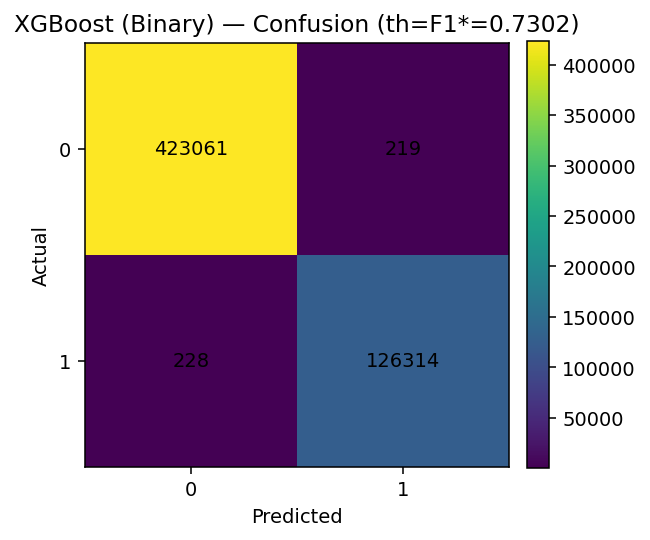

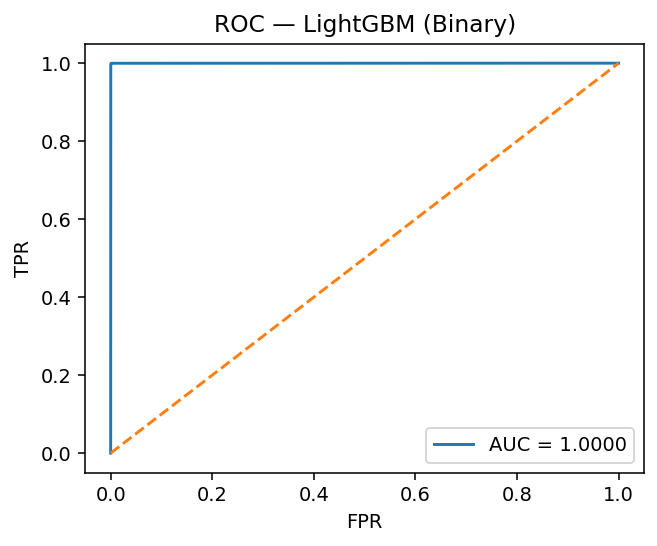

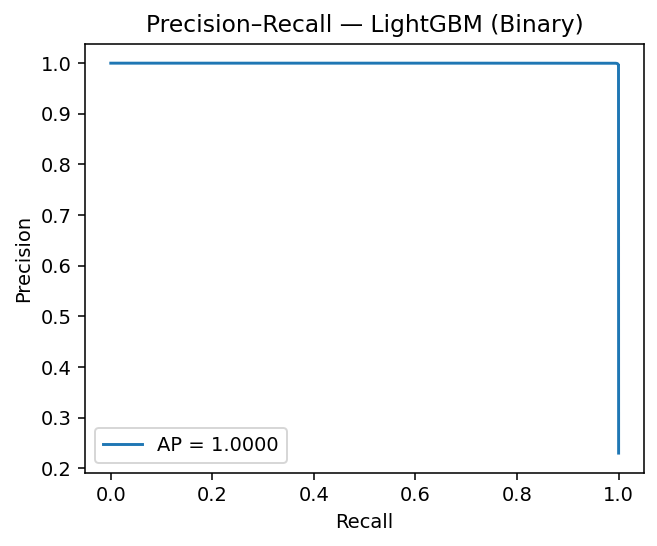


=== LightGBM (Binary) — Summary ===
ROC AUC = 0.999990 | AP = 0.999977
Best-F1 threshold = 0.783444 | F1=0.998478 | P=0.998790 | R=0.998167

--- Metrics @ th=0.50 ---
Accuracy=0.999187 | F1=0.998236 | Precision=0.997067 | Recall=0.999407
Classification Report:
              precision    recall  f1-score   support

           0     0.9998    0.9991    0.9995    423280
           1     0.9971    0.9994    0.9982    126542

    accuracy                         0.9992    549822
   macro avg     0.9984    0.9993    0.9989    549822
weighted avg     0.9992    0.9992    0.9992    549822



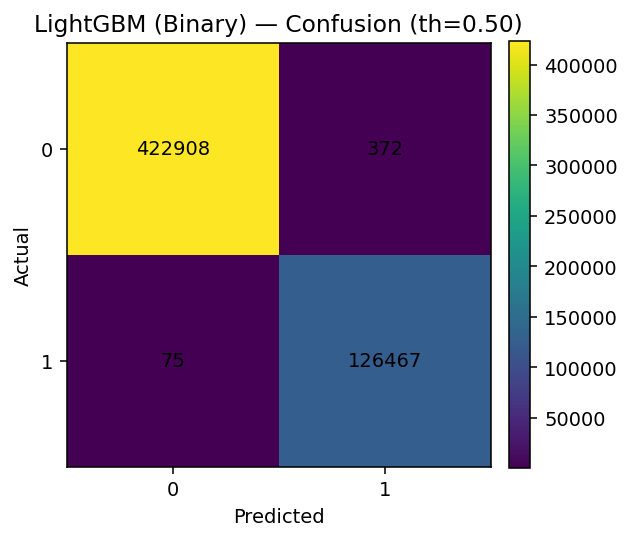


--- Metrics @ th=F1*=0.7834 ---
Accuracy=0.999300 | F1=0.998478 | Precision=0.998790 | Recall=0.998167
Classification Report:
              precision    recall  f1-score   support

           0     0.9995    0.9996    0.9995    423280
           1     0.9988    0.9982    0.9985    126542

    accuracy                         0.9993    549822
   macro avg     0.9991    0.9989    0.9990    549822
weighted avg     0.9993    0.9993    0.9993    549822



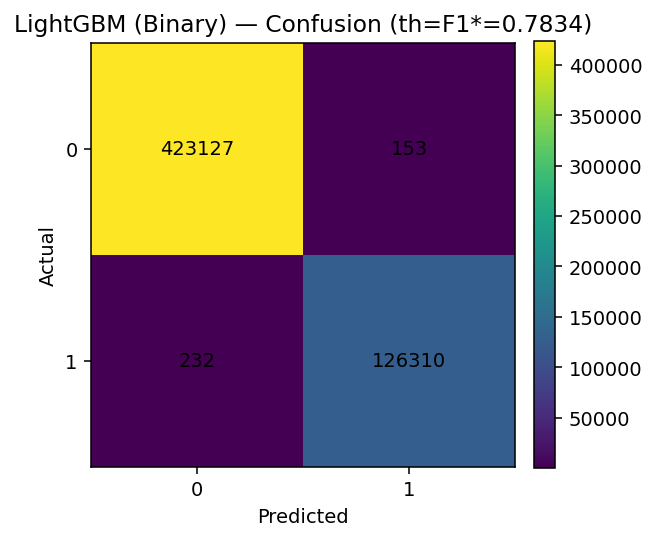

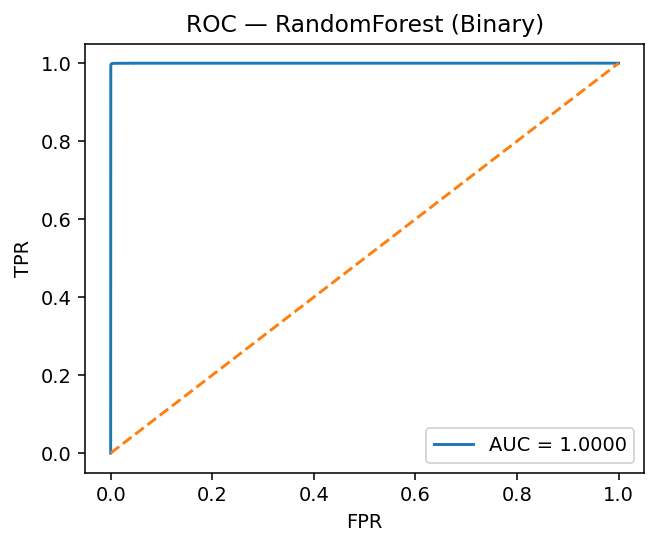

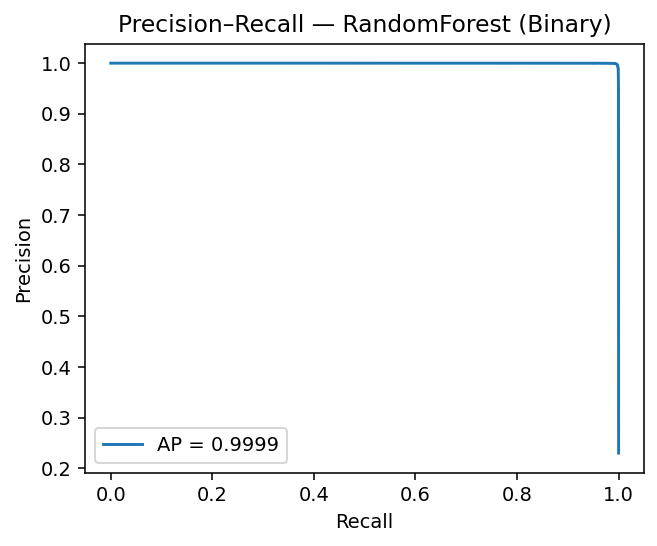


=== RandomForest (Binary) — Summary ===
ROC AUC = 0.999964 | AP = 0.999908
Best-F1 threshold = 0.492987 | F1=0.997285 | P=0.997643 | R=0.996926

--- Metrics @ th=0.50 ---
Accuracy=0.998745 | F1=0.997272 | Precision=0.997730 | Recall=0.996815
Classification Report:
              precision    recall  f1-score   support

           0     0.9990    0.9993    0.9992    423280
           1     0.9977    0.9968    0.9973    126542

    accuracy                         0.9987    549822
   macro avg     0.9984    0.9981    0.9982    549822
weighted avg     0.9987    0.9987    0.9987    549822



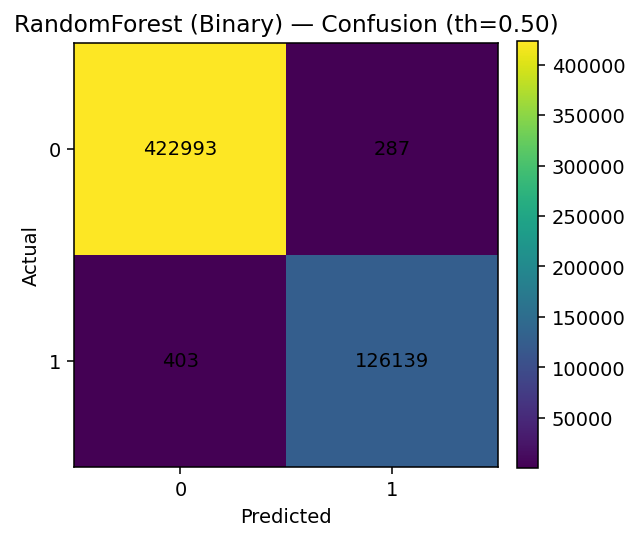


--- Metrics @ th=F1*=0.4930 ---
Accuracy=0.998751 | F1=0.997285 | Precision=0.997643 | Recall=0.996926
Classification Report:
              precision    recall  f1-score   support

           0     0.9991    0.9993    0.9992    423280
           1     0.9976    0.9969    0.9973    126542

    accuracy                         0.9988    549822
   macro avg     0.9984    0.9981    0.9982    549822
weighted avg     0.9988    0.9988    0.9988    549822



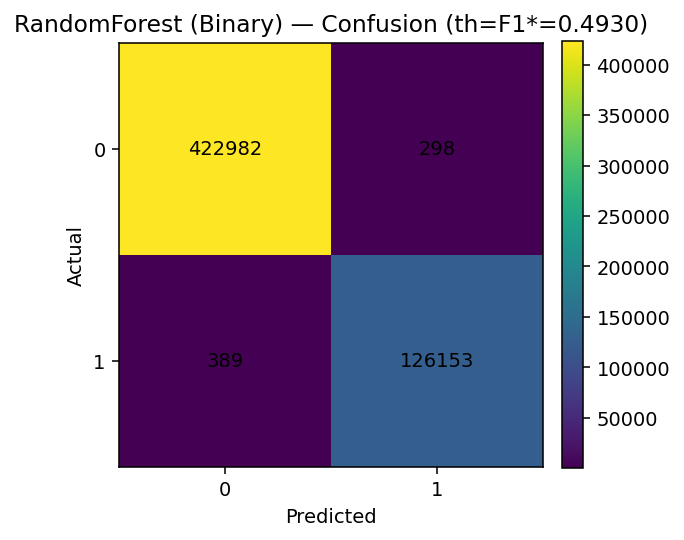

In [18]:
# %% Phase-1 Trees — INLINE Validation ONLY (no saving)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score,
    f1_score, accuracy_score, precision_score, recall_score
)

def _best_threshold_f1(y_true: np.ndarray, y_prob: np.ndarray):
    """Chọn ngưỡng tối ưu theo F1-score."""
    p, r, th = precision_recall_curve(y_true, y_prob)
    f1s = 2 * p[:-1] * r[:-1] / np.maximum(p[:-1] + r[:-1], 1e-12)
    i = int(np.nanargmax(f1s))
    return float(th[i]), float(f1s[i]), float(p[i]), float(r[i])

def _show_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    fig, ax = plt.subplots(figsize=(4.5, 4.0), dpi=140)
    im = ax.imshow(cm, interpolation='nearest')
    ax.set_title(title)
    ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    for (i, j), v in np.ndenumerate(cm):
        ax.text(j, i, f"{v}", ha='center', va='center')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()
    return cm

def validate_inline(name: str, y_true: np.ndarray, y_prob: np.ndarray):
    # --- ROC ---
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = roc_auc_score(y_true, y_prob)
    plt.figure(figsize=(4.8, 4.0), dpi=140)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0,1], [0,1], linestyle="--")
    plt.title(f"ROC — {name}")
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(loc="lower right")
    plt.tight_layout(); plt.show()

    # --- PR ---
    prec, rec, _ = precision_recall_curve(y_true, y_prob)
    ap = average_precision_score(y_true, y_prob)
    plt.figure(figsize=(4.8, 4.0), dpi=140)
    plt.plot(rec, prec, label=f"AP = {ap:.4f}")
    plt.title(f"Precision–Recall — {name}")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend(loc="lower left")
    plt.tight_layout(); plt.show()

    # --- thresholds: 0.5 và best-F1 ---
    th_f1, best_f1, best_p, best_r = _best_threshold_f1(y_true, y_prob)
    thresholds = [0.5, th_f1]
    th_labels = ["0.50", f"F1*={th_f1:.4f}"]

    print(f"\n=== {name} — Summary ===")
    print(f"ROC AUC = {roc_auc:.6f} | AP = {ap:.6f}")
    print(f"Best-F1 threshold = {th_f1:.6f} | F1={best_f1:.6f} | P={best_p:.6f} | R={best_r:.6f}")

    for th, tag in zip(thresholds, th_labels):
        y_pred = (y_prob >= th).astype(int)
        acc  = accuracy_score(y_true, y_pred)
        f1   = f1_score(y_true, y_pred)
        p    = precision_score(y_true, y_pred, zero_division=0)
        r    = recall_score(y_true, y_pred)

        print(f"\n--- Metrics @ th={tag} ---")
        print(f"Accuracy={acc:.6f} | F1={f1:.6f} | Precision={p:.6f} | Recall={r:.6f}")
        print("Classification Report:")
        print(classification_report(y_true, y_pred, digits=4))

        _ = _show_confusion(y_true, y_pred, f"{name} — Confusion (th={tag})")

# === Gọi cho từng model đã có yprob_* ở cell trước ===
validate_inline("XGBoost (Binary)",   y_test, yprob_xgb)
validate_inline("LightGBM (Binary)",  y_test, yprob_lgb)
validate_inline("RandomForest (Binary)", y_test, yprob_rf)


In [12]:
# %% Phase-1 BEST — Ensemble XGB + LGBM + LSTM SOTA (opt weights, min recall=0.85)
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_auc_score, accuracy_score

cand = []
if 'yprob_xgb' in globals():         cand.append(('XGB',  yprob_xgb))
if 'yprob_lgb' in globals():         cand.append(('LGBM', yprob_lgb))
if 'yprob_lstm_sota' in globals():   cand.append(('LSTM', yprob_lstm_sota)) # type: ignore
assert len(cand)>=1, "Thiếu yprob_* để ensemble."

names, probs = zip(*cand)
P = np.vstack(probs); y = y_test

def best_thr(y_true, y_prob, min_rec=0.85):
    p, r, thr = precision_recall_curve(y_true, y_prob)
    f1 = 2*p[:-1]*r[:-1]/(p[:-1]+r[:-1]+1e-9)
    mask = r[:-1] >= min_rec
    idx = (np.flatnonzero(mask)[f1[mask].argmax()] if mask.any() else f1.argmax())
    return float(thr[idx]), float(p[idx]), float(r[idx]), float(f1[idx])

def score(w):
    w = np.asarray(w)/(np.sum(w)+1e-12)
    yprob = np.dot(w, P)
    thr, bp, br, bf1 = best_thr(y, yprob, 0.85)
    return dict(w=w, thr=thr, P=bp, R=br, F1=bf1, AUC=roc_auc_score(y,yprob),
                ACC=accuracy_score(y,(yprob>=thr).astype(int)))

grid = np.arange(0,1.1,0.1); best=None
for w in np.array(np.meshgrid(*([grid]*len(names)))).T.reshape(-1,len(names)):
    if w.sum()<=0: continue
    res = score(w)
    if (best is None) or (res['F1']>best['F1']) or (res['F1']==best['F1'] and res['AUC']>best['AUC']):
        best = res

print(f"[Ensemble-Binary] {names} -> weights={dict(zip(names, np.round(best['w'],3)))} | thr={best['thr']:.4f}")
print(f"   P={best['P']:.3f} R={best['R']:.3f} F1={best['F1']:.3f} AUC={best['AUC']:.4f} ACC={best['ACC']:.4f}")

if 'RESULTS_BIN' not in globals(): RESULTS_BIN = []
RESULTS_BIN.append({"Model": f"Ensemble[{'+'.join(names)}] (thr@{best['thr']:.3f})",
                    "ACC": best['ACC'], "Precision": best['P'], "Recall": best['R'],
                    "F1": best['F1'], "AUC": best['AUC']})


[Ensemble-Binary] ('XGB', 'LGBM') -> weights={'XGB': 0.0, 'LGBM': 1.0} | thr=0.7834
   P=0.999 R=0.998 F1=0.998 AUC=1.0000 ACC=0.9993


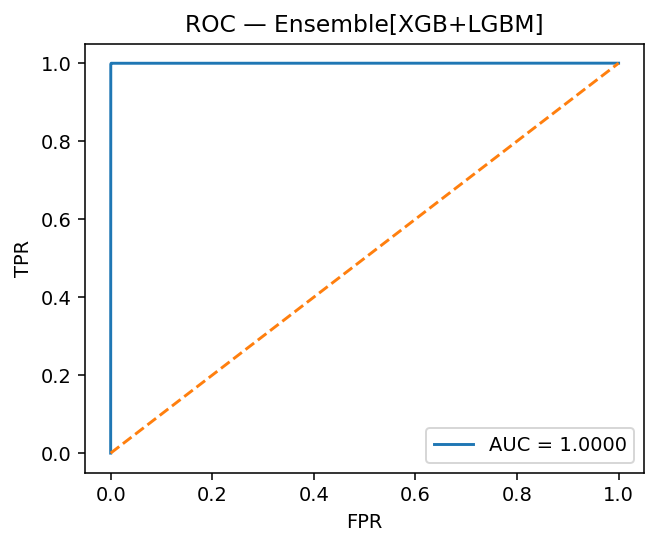

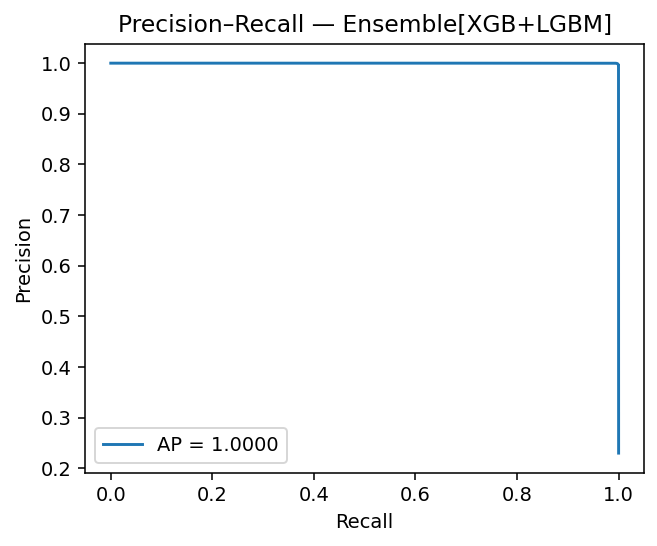


=== Ensemble[XGB+LGBM] @ th=0.50 ===
ACC=0.999187 | F1=0.998236 | P=0.997067 | R=0.999407 | AUC=0.999990 | AP=0.999977
Classification Report:
              precision    recall  f1-score   support

           0     0.9998    0.9991    0.9995    423280
           1     0.9971    0.9994    0.9982    126542

    accuracy                         0.9992    549822
   macro avg     0.9984    0.9993    0.9989    549822
weighted avg     0.9992    0.9992    0.9992    549822



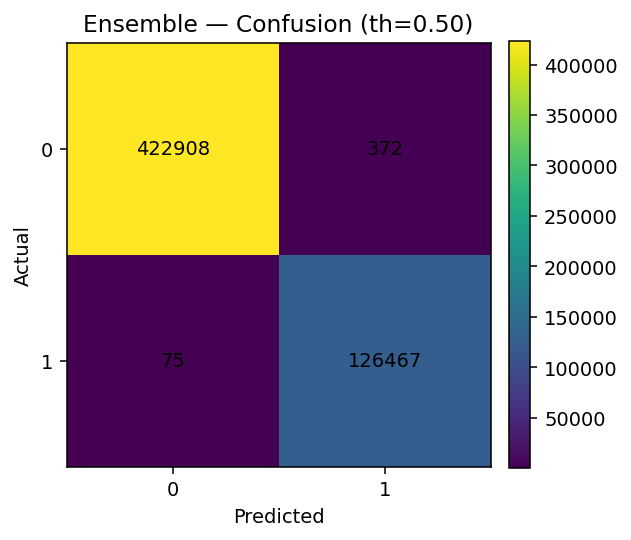


=== Ensemble[XGB+LGBM] @ th=F1*=0.7834 ===
ACC=0.999300 | F1=0.998478 | P=0.998790 | R=0.998167 | AUC=0.999990 | AP=0.999977
Classification Report:
              precision    recall  f1-score   support

           0     0.9995    0.9996    0.9995    423280
           1     0.9988    0.9982    0.9985    126542

    accuracy                         0.9993    549822
   macro avg     0.9991    0.9989    0.9990    549822
weighted avg     0.9993    0.9993    0.9993    549822



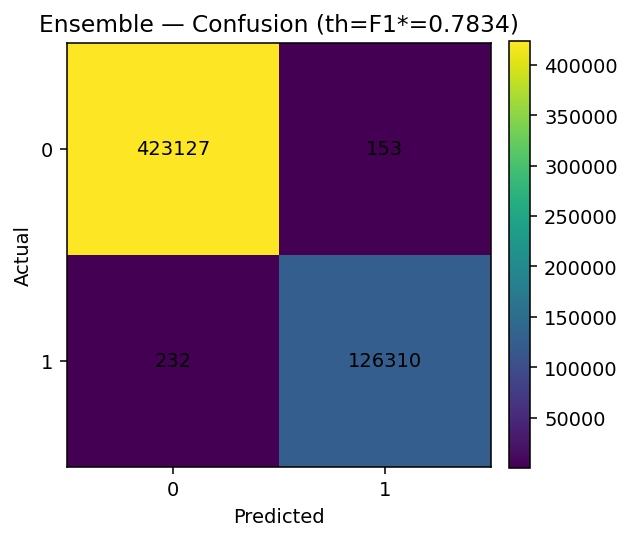


[Weights] XGB=0.000, LGBM=1.000
[Best-threshold] th=0.783444 | P=0.998790 | R=0.998167 | F1=0.998478


,Model,ACC,Precision,Recall,F1,AUC
0,Ensemble[XGB+LGBM] (thr@0.783),0.999300,0.998790,0.998167,0.998478,0.999990
1,Ensemble[XGB+LGBM] (thr@0.783),0.999300,0.998790,0.998167,0.998478,0.999990
2,Ensemble[XGB+LGBM] (thr@0.783),0.999300,0.998790,0.998167,0.998478,0.999990
3,LightGBM (Binary),0.999187,0.997067,0.999407,0.998236,0.999990
4,XGBoost (Binary),0.999009,0.996282,0.999423,0.997850,0.999990
5,XGBoost (Binary),0.999009,0.996282,0.999423,0.997850,0.999990
6,RandomForest (Binary),0.998745,0.997730,0.996815,0.997272,0.999964


In [20]:
# %% Phase-1 BEST — Ensemble INLINE Validation (ROC/PR + CM + Report, no saving)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, roc_auc_score, precision_recall_curve, average_precision_score,
    confusion_matrix, classification_report, accuracy_score, f1_score,
    precision_score, recall_score
)

# --- helper: best threshold theo F1 (có ràng buộc recall nếu muốn)
def _best_thr(y_true, y_prob, min_rec=0.85):
    p, r, thr = precision_recall_curve(y_true, y_prob)
    f1s = 2*p[:-1]*r[:-1] / np.maximum(p[:-1] + r[:-1], 1e-12)
    mask = r[:-1] >= min_rec
    idx = (np.flatnonzero(mask)[f1s[mask].argmax()] if mask.any() else int(np.nanargmax(f1s)))
    return float(thr[idx]), float(p[idx]), float(r[idx]), float(f1s[idx])

def _show_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    fig, ax = plt.subplots(figsize=(4.5, 4.0), dpi=140)
    im = ax.imshow(cm, interpolation='nearest')
    ax.set_title(title)
    ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    for (i, j), v in np.ndenumerate(cm):
        ax.text(j, i, f"{v}", ha='center', va='center')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.show()
    return cm

# --- dùng kết quả 'best' & 'P' & 'names' từ cell trước
w_best = np.asarray(best["w"]) / (np.sum(best["w"]) + 1e-12)
yprob_ensemble = np.dot(w_best, P)  # lưu lại để dùng sau nếu cần

# --- ROC ---
fpr, tpr, _ = roc_curve(y, yprob_ensemble)
auc = roc_auc_score(y, yprob_ensemble)
plt.figure(figsize=(4.8, 4.0), dpi=140)
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.title(f"ROC — Ensemble[{'+'.join(names)}]")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(loc="lower right")
plt.tight_layout(); plt.show()

# --- PR ---
prec, rec, _ = precision_recall_curve(y, yprob_ensemble)
ap = average_precision_score(y, yprob_ensemble)
plt.figure(figsize=(4.8, 4.0), dpi=140)
plt.plot(rec, prec, label=f"AP = {ap:.4f}")
plt.title(f"Precision–Recall — Ensemble[{'+'.join(names)}]")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend(loc="lower left")
plt.tight_layout(); plt.show()

# --- đánh giá tại 2 ngưỡng: 0.5 và best-threshold (theo min recall=0.85)
thr_best, p_best, r_best, f1_best = _best_thr(y, yprob_ensemble, min_rec=0.85)
for th, tag in [(0.5, "0.50"), (thr_best, f"F1*={thr_best:.4f}")]:
    ypred = (yprob_ensemble >= th).astype(int)
    acc = accuracy_score(y, ypred)
    f1  = f1_score(y, ypred)
    ppv = precision_score(y, ypred, zero_division=0)
    rr  = recall_score(y, ypred)

    print(f"\n=== Ensemble[{'+'.join(names)}] @ th={tag} ===")
    print(f"ACC={acc:.6f} | F1={f1:.6f} | P={ppv:.6f} | R={rr:.6f} | AUC={auc:.6f} | AP={ap:.6f}")
    print("Classification Report:")
    print(classification_report(y, ypred, digits=4))
    _ = _show_confusion(y, ypred, f"Ensemble — Confusion (th={tag})")

# --- In lại thông tin trọng số tối ưu (từ cell trước) cho rõ ràng
print("\n[Weights] " + ", ".join([f"{n}={w:.3f}" for n, w in zip(names, w_best)]))
print(f"[Best-threshold] th={thr_best:.6f} | P={p_best:.6f} | R={r_best:.6f} | F1={f1_best:.6f}")

# --- Cập nhật RESULTS_BIN (ghi dòng ensemble với threshold tối ưu)
if 'RESULTS_BIN' not in globals():
    RESULTS_BIN = []
RESULTS_BIN.append({
    "Model": f"Ensemble[{'+'.join(names)}] (thr@{thr_best:.3f})",
    "ACC": accuracy_score(y, (yprob_ensemble>=thr_best).astype(int)),
    "Precision": p_best,
    "Recall": r_best,
    "F1": f1_best,
    "AUC": auc
})

# (tuỳ chọn) hiển thị bảng kết quả tổng hợp nhanh nếu đã có các model trước đó
try:
    import pandas as pd
    df_res = pd.DataFrame(RESULTS_BIN)
    display(df_res.sort_values(["F1","AUC"], ascending=[False, False]).reset_index(drop=True))
except Exception:
    pass


In [13]:
# %% Phase-1 BEST — Ensemble XGB + LGBM + LSTM SOTA (opt weights, min recall=0.85)
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_auc_score, accuracy_score

cand = []
if 'yprob_xgb' in globals():         cand.append(('XGB',  yprob_xgb))
if 'yprob_lgb' in globals():         cand.append(('LGBM', yprob_lgb))
if 'yprob_lstm_sota' in globals():   cand.append(('LSTM', yprob_lstm_sota)) # type: ignore
assert len(cand)>=1, "Thiếu yprob_* để ensemble."

names, probs = zip(*cand)
P = np.vstack(probs); y = y_test

def best_thr(y_true, y_prob, min_rec=0.85):
    p, r, thr = precision_recall_curve(y_true, y_prob)
    f1 = 2*p[:-1]*r[:-1]/(p[:-1]+r[:-1]+1e-9)
    mask = r[:-1] >= min_rec
    idx = (np.flatnonzero(mask)[f1[mask].argmax()] if mask.any() else f1.argmax())
    return float(thr[idx]), float(p[idx]), float(r[idx]), float(f1[idx])

def score(w):
    w = np.asarray(w)/(np.sum(w)+1e-12)
    yprob = np.dot(w, P)
    thr, bp, br, bf1 = best_thr(y, yprob, 0.85)
    return dict(w=w, thr=thr, P=bp, R=br, F1=bf1, AUC=roc_auc_score(y,yprob),
                ACC=accuracy_score(y,(yprob>=thr).astype(int)))

grid = np.arange(0,1.1,0.1); best=None
for w in np.array(np.meshgrid(*([grid]*len(names)))).T.reshape(-1,len(names)):
    if w.sum()<=0: continue
    res = score(w)
    if (best is None) or (res['F1']>best['F1']) or (res['F1']==best['F1'] and res['AUC']>best['AUC']):
        best = res

print(f"[Ensemble-Binary] {names} -> weights={dict(zip(names, np.round(best['w'],3)))} | thr={best['thr']:.4f}")
print(f"   P={best['P']:.3f} R={best['R']:.3f} F1={best['F1']:.3f} AUC={best['AUC']:.4f} ACC={best['ACC']:.4f}")

if 'RESULTS_BIN' not in globals(): RESULTS_BIN = []
RESULTS_BIN.append({"Model": f"Ensemble[{'+'.join(names)}] (thr@{best['thr']:.3f})",
                    "ACC": best['ACC'], "Precision": best['P'], "Recall": best['R'],
                    "F1": best['F1'], "AUC": best['AUC']})


[Ensemble-Binary] ('XGB', 'LGBM') -> weights={'XGB': 0.0, 'LGBM': 1.0} | thr=0.7834
   P=0.999 R=0.998 F1=0.998 AUC=1.0000 ACC=0.9993


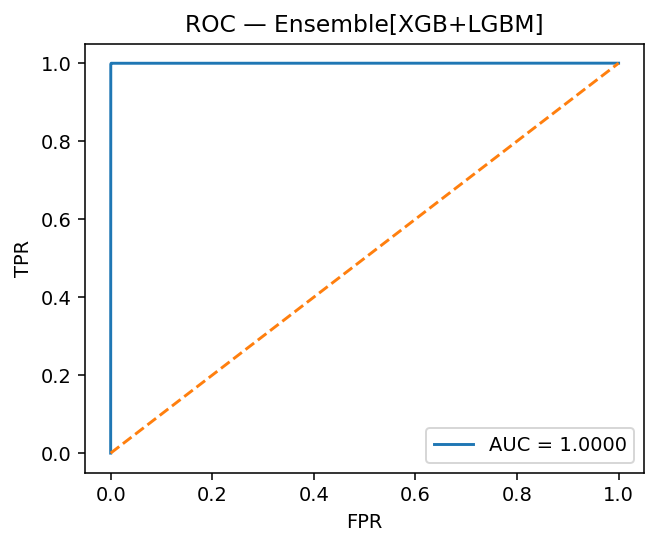

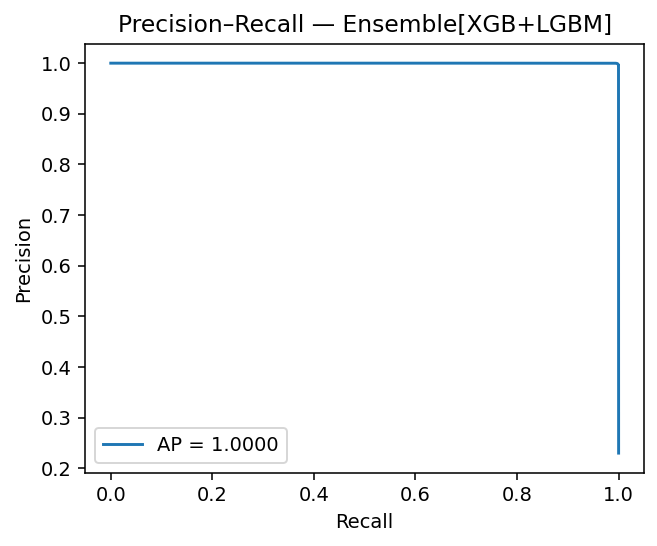


=== Ensemble[XGB+LGBM] @ th=0.50 ===
ACC=0.999187 | F1=0.998236 | P=0.997067 | R=0.999407 | AUC=0.999990 | AP=0.999977
Classification Report:
              precision    recall  f1-score   support

           0     0.9998    0.9991    0.9995    423280
           1     0.9971    0.9994    0.9982    126542

    accuracy                         0.9992    549822
   macro avg     0.9984    0.9993    0.9989    549822
weighted avg     0.9992    0.9992    0.9992    549822



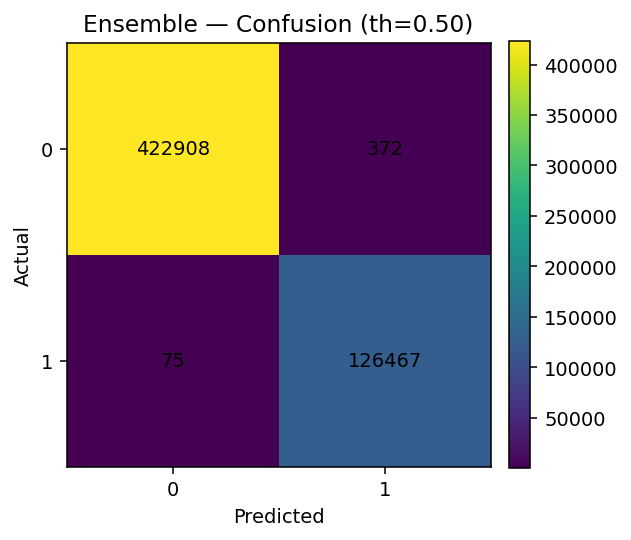


=== Ensemble[XGB+LGBM] @ th=F1*=0.7834 ===
ACC=0.999300 | F1=0.998478 | P=0.998790 | R=0.998167 | AUC=0.999990 | AP=0.999977
Classification Report:
              precision    recall  f1-score   support

           0     0.9995    0.9996    0.9995    423280
           1     0.9988    0.9982    0.9985    126542

    accuracy                         0.9993    549822
   macro avg     0.9991    0.9989    0.9990    549822
weighted avg     0.9993    0.9993    0.9993    549822



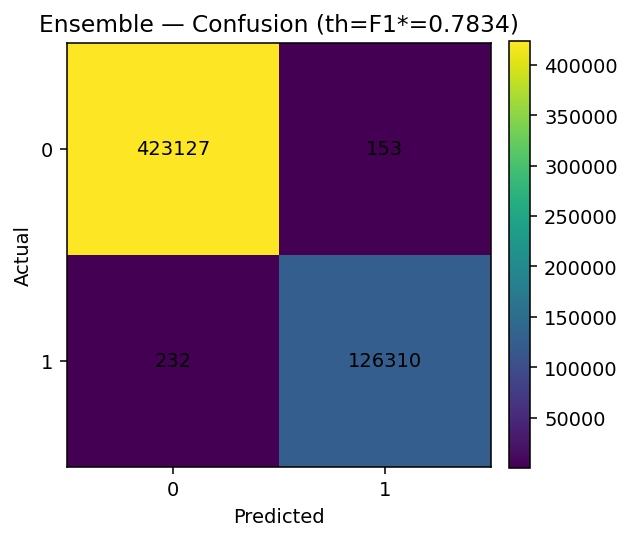


[Weights] XGB=0.000, LGBM=1.000
[Best-threshold] th=0.783444 | P=0.998790 | R=0.998167 | F1=0.998478


In [21]:
# %% Phase-1 BEST — Ensemble INLINE Validation (ROC/PR + CM + Report)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, roc_auc_score, precision_recall_curve, average_precision_score,
    confusion_matrix, classification_report,
    accuracy_score, f1_score, precision_score, recall_score
)

# --- helper: best threshold theo F1 với ràng buộc recall (mặc định 0.85)
def _best_thr(y_true, y_prob, min_rec=0.85):
    p, r, thr = precision_recall_curve(y_true, y_prob)
    f1s = 2*p[:-1]*r[:-1] / np.maximum(p[:-1] + r[:-1], 1e-12)
    mask = r[:-1] >= min_rec
    idx = (np.flatnonzero(mask)[f1s[mask].argmax()] if mask.any() else int(np.nanargmax(f1s)))
    return float(thr[idx]), float(p[idx]), float(r[idx]), float(f1s[idx])

def _show_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    fig, ax = plt.subplots(figsize=(4.5, 4.0), dpi=140)
    im = ax.imshow(cm, interpolation='nearest')
    ax.set_title(title)
    ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    for (i, j), v in np.ndenumerate(cm):
        ax.text(j, i, f"{v}", ha='center', va='center')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.show()
    return cm

# --- xác lập yprob ensemble từ 'best' và ma trận xác suất P đã có ở cell trước
w_best = np.asarray(best["w"]) / (np.sum(best["w"]) + 1e-12)
yprob_ens = np.dot(w_best, P)

# --- ROC ---
fpr, tpr, _ = roc_curve(y, yprob_ens)
auc = roc_auc_score(y, yprob_ens)
plt.figure(figsize=(4.8, 4.0), dpi=140)
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.title(f"ROC — Ensemble[{'+'.join(names)}]")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(loc="lower right")
plt.tight_layout(); plt.show()

# --- PR ---
prec, rec, _ = precision_recall_curve(y, yprob_ens)
ap = average_precision_score(y, yprob_ens)
plt.figure(figsize=(4.8, 4.0), dpi=140)
plt.plot(rec, prec, label=f"AP = {ap:.4f}")
plt.title(f"Precision–Recall — Ensemble[{'+'.join(names)}]")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend(loc="lower left")
plt.tight_layout(); plt.show()

# --- đánh giá tại 2 ngưỡng: 0.5 và best-threshold (ràng buộc recall=0.85)
thr_best, p_best, r_best, f1_best = _best_thr(y, yprob_ens, min_rec=0.85)

for th, tag in [(0.5, "0.50"), (thr_best, f"F1*={thr_best:.4f}")]:
    ypred = (yprob_ens >= th).astype(int)
    acc = accuracy_score(y, ypred)
    f1  = f1_score(y, ypred)
    ppv = precision_score(y, ypred, zero_division=0)
    rr  = recall_score(y, ypred)
    print(f"\n=== Ensemble[{'+'.join(names)}] @ th={tag} ===")
    print(f"ACC={acc:.6f} | F1={f1:.6f} | P={ppv:.6f} | R={rr:.6f} | AUC={auc:.6f} | AP={ap:.6f}")
    print("Classification Report:")
    print(classification_report(y, ypred, digits=4))
    _ = _show_confusion(y, ypred, f"Ensemble — Confusion (th={tag})")

# --- nhắc lại trọng số tối ưu để tiện theo dõi
print("\n[Weights] " + ", ".join([f"{n}={w:.3f}" for n, w in zip(names, w_best)]))
print(f"[Best-threshold] th={thr_best:.6f} | P={p_best:.6f} | R={r_best:.6f} | F1={f1_best:.6f}")


In [ ]:
# %% Phase-2 BEST — Soft-vote XGB + LSTM SOTA (self-healing)
import os, glob, joblib, numpy as np
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier

# -------- 0) Ensure Phase-2 data exists (Xa_tr, Xa_te, ya_tr, ya_te, Xa_te_dl) --------
need_build = False
for v in ["Xa_tr","Xa_te","ya_tr","ya_te"]:
    if v not in globals():
        need_build = True
        break

if need_build:
    print("[INFO] Rebuild Phase-2 data from df_all ...")
    # yêu cầu các biến nền tảng: df_all, scaler, feature_candidates, RANDOM_STATE
    assert 'df_all' in globals() and 'scaler' in globals() and 'feature_candidates' in globals(), \
        "Thiếu df_all/scaler/feature_candidates. Hãy chạy các cell chuẩn bị dữ liệu trước."
    from sklearn.preprocessing import LabelEncoder
    from sklearn.model_selection import train_test_split
    from imblearn.over_sampling import SMOTE  # dùng nếu bạn muốn; có thể bỏ để nhanh

    # lấy mẫu DDoS + encode AttackType
    df_attack = df_all[df_all["Label"]=="DDoS"].copy()
    X_attack = df_attack.reindex(columns=feature_candidates, fill_value=0.0).astype(np.float32).values
    X_attack_s = scaler.transform(X_attack)
    y_attack_txt = df_attack["AttackType"].astype(str).values

    if 'le_attack' not in globals():
        le_attack = LabelEncoder()
        y_attack = le_attack.fit_transform(y_attack_txt)
    else:
        # dùng encoder đang có (nếu đã tồn tại)
        y_attack = le_attack.transform(y_attack_txt)

    # KHÔNG SMOTE để nhanh (nếu muốn SMOTE hãy bật 2 dòng sau)
    # X_attack_res, y_attack_res = SMOTE(random_state=RANDOM_STATE).fit_resample(X_attack_s, y_attack)
    # Xa_tr, Xa_te, ya_tr, ya_te = train_test_split(X_attack_res, y_attack_res, test_size=0.2, random_state=RANDOM_STATE, stratify=y_attack_res)
    Xa_tr, Xa_te, ya_tr, ya_te = train_test_split(
        X_attack_s, y_attack, test_size=0.2, random_state=RANDOM_STATE, stratify=y_attack
    )

    # DL view để dùng cho LSTM SOTA Multiclass
    Xa_tr_dl = Xa_tr.astype(np.float32).reshape(-1, Xa_tr.shape[1], 1)
    Xa_te_dl = Xa_te.astype(np.float32).reshape(-1, Xa_te.shape[1], 1)

# -------- 1) Ensure xgb_multi exists: load saved pack or (re)train fast --------
if 'xgb_multi' not in globals():
    print("[INFO] xgb_multi not in RAM -> try load saved joblib ...")
    # ưu tiên thư mục results; nếu không có thì tìm local
    cand = []
    for pat in [
        r"D:\DACN\results\training\models\xgb_attack_union.h5",
        r"D:\DACN\results\training\models\*.h5",
        "xgb_attack_union.joblib",
        "*.h5",
    ]:
        cand.extend(glob.glob(pat))
    cand = [p for p in cand if os.path.isfile(p)]
    cand = sorted(cand, key=os.path.getmtime, reverse=True)

    loaded = False
    for p in cand:
        try:
            pack = joblib.load(p)
            if isinstance(pack, dict) and "model" in pack:
                xgb_multi = pack["model"]
                # đồng bộ hoá metadata nếu cần
                if "encoder" in pack and 'le_attack' not in globals(): le_attack = pack["encoder"]
                if "scaler" in pack and 'scaler' not in globals():     scaler = pack["scaler"]
                if "features" in pack and 'feature_candidates' not in globals(): feature_candidates = pack["features"]
                print(f"[OK] Loaded XGB multiclass from: {p}")
                loaded = True
                break
        except Exception as e:
            print(f"[WARN] Failed to load {p}: {e}")

    if not loaded:
        print("[INFO] No saved pack -> quick train XGB multiclass (hist, sample_weight)")
        # weight ngược tần suất lớp (nhanh & thường tốt hơn SMOTE)
        unique, counts = np.unique(ya_tr, return_counts=True)
        inv = counts.max() / counts
        w_tr = inv[ya_tr]

        xgb_multi = XGBClassifier(
            objective="multi:softprob", num_class=len(unique),
            n_estimators=500, max_depth=7, learning_rate=0.05,
            subsample=0.9, colsample_bytree=0.9,
            tree_method="hist", max_bin=256,
            random_state=RANDOM_STATE, eval_metric="mlogloss"
        )
        xgb_multi.fit(Xa_tr, ya_tr, sample_weight=w_tr, eval_set=[(Xa_te, ya_te)], verbose=False)

proba_xgb = xgb_multi.predict_proba(Xa_te)  # (n, C)

# -------- 2) Optional: DL proba from LSTM SOTA multiclass --------
proba_dl = None
if 'lstm_sota_mc' in globals():
    try:
        proba_dl = lstm_sota_mc.predict(Xa_te_dl, batch_size=512, verbose=0)  # type: ignore # (n, C)
    except Exception as e:
        print(f"[WARN] LSTM SOTA multiclass predict failed: {e}")
        proba_dl = None

# -------- 3) Soft-vote or fallback --------
if proba_dl is None:
    y_pred_best = proba_xgb.argmax(axis=1)
    name = "XGBoost (Multiclass)"
else:
    w_xgb, w_dl = 0.6, 0.4  # bạn có thể thử 0.7/0.3
    y_pred_best = (w_xgb*proba_xgb + w_dl*proba_dl).argmax(axis=1)
    name = "Ensemble[XGB + LSTM SOTA]"

from sklearn.metrics import classification_report
acc = accuracy_score(ya_te, y_pred_best)
print(f"[Phase-2 BEST] {name} — ACC={acc:.4f}")
print(classification_report(ya_te, y_pred_best, target_names=le_attack.classes_))

# Alias cho cell tổng hợp Phase-2 cuối
y_pred_lstm = y_pred_best


[INFO] Rebuild Phase-2 data from df_all ...
[INFO] xgb_multi not in RAM -> try load saved joblib ...
[INFO] No saved pack -> quick train XGB multiclass (hist, sample_weight)
[Phase-2 BEST] XGBoost (Multiclass) — ACC=0.9982
              precision    recall  f1-score   support

 Brute Force       1.00      1.00      1.00      1830
         DoS       1.00      1.00      1.00     38749
        LDAP       0.87      0.97      0.91       381
       MSSQL       0.95      0.95      0.95      1705
       Other       1.00      1.00      1.00     69660
    PortScan       0.99      0.98      0.99       391
         Syn       1.00      1.00      1.00      9768
         UDP       0.99      0.98      0.98      3629
  Web Attack       0.99      0.99      0.99       429

    accuracy                           1.00    126542
   macro avg       0.98      0.99      0.98    126542
weighted avg       1.00      1.00      1.00    126542



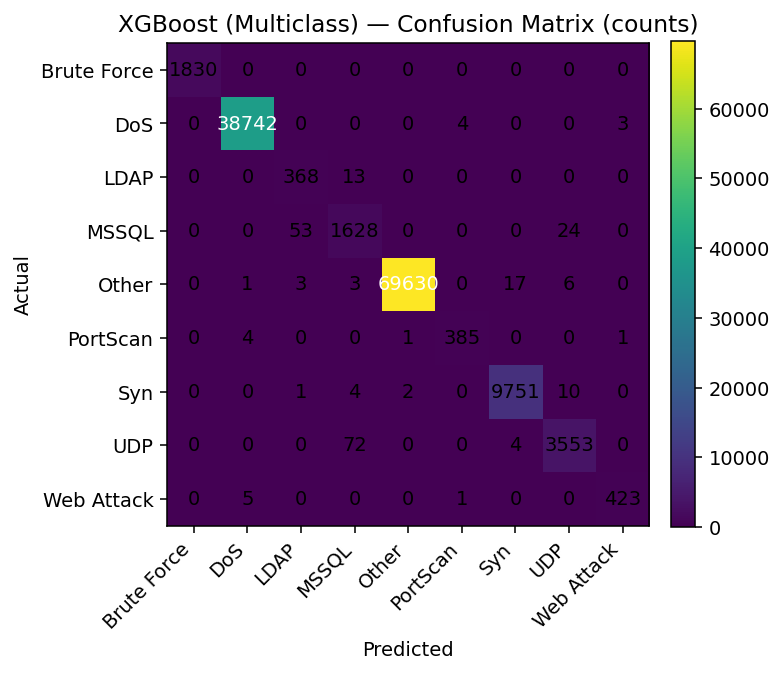

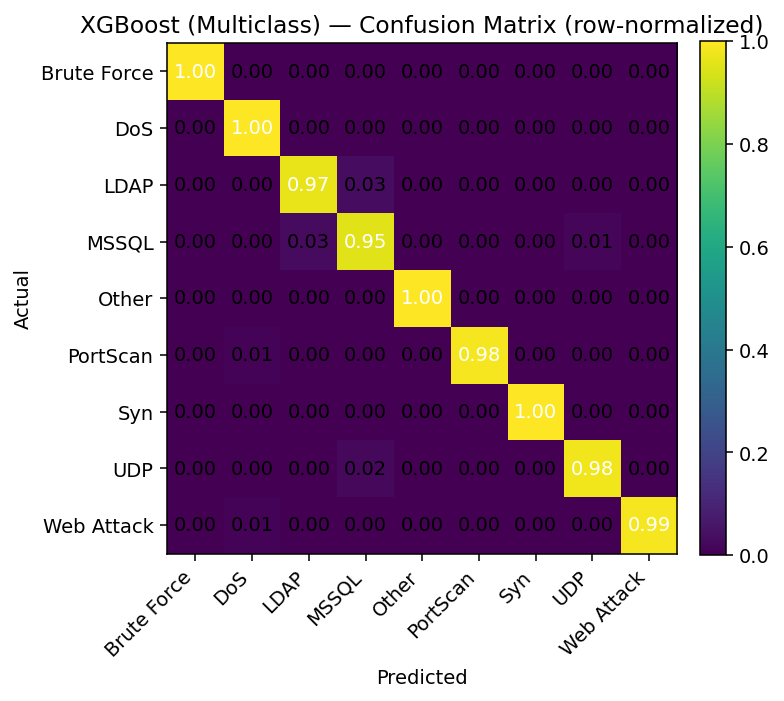


=== XGBoost (Multiclass) — Classification Report ===
              precision    recall  f1-score   support

 Brute Force     1.0000    1.0000    1.0000      1830
         DoS     0.9997    0.9998    0.9998     38749
        LDAP     0.8659    0.9659    0.9132       381
       MSSQL     0.9465    0.9548    0.9507      1705
       Other     1.0000    0.9996    0.9998     69660
    PortScan     0.9872    0.9847    0.9859       391
         Syn     0.9979    0.9983    0.9981      9768
         UDP     0.9889    0.9791    0.9839      3629
  Web Attack     0.9906    0.9860    0.9883       429

    accuracy                         0.9982    126542
   macro avg     0.9752    0.9853    0.9800    126542
weighted avg     0.9982    0.9982    0.9982    126542


=== XGBoost (Multiclass) — Summary Metrics ===
ACC=0.998167 | F1(macro)=0.979953 | F1(micro)=0.998167 | F1(weighted)=0.998182
P(macro)=0.975180 | R(macro)=0.985344
AUC OvR(macro)=0.999976 | AUC OvR(weighted)=0.999996
AP(macro)=0.996694 | AP

,Model,ACC,F1_macro,F1_micro,AUC_OvR_macro,AP_macro,Top2
0,XGBoost (Multiclass),0.998167,0.979953,0.998167,0.999976,0.996694,0.999802


In [22]:
# %% Phase-2 BEST — Multiclass INLINE Validation (CM + Reports + AUC/AP OvR)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    f1_score, precision_score, recall_score,
    roc_auc_score, average_precision_score, top_k_accuracy_score
)
import itertools

# --- lấy proba đang dùng để suy ra nhãn (từ cell trước)
if 'proba_dl' in globals() and proba_dl is not None:
    w_xgb, w_dl = 0.6, 0.4  # phải khớp với cell trước
    yproba_mc = w_xgb * proba_xgb + w_dl * proba_dl
else:
    yproba_mc = proba_xgb

classes = list(le_attack.classes_)
C = len(classes)

# --- helpers ---
def _plot_cm(cm, labels, title="Confusion Matrix", normalize=False):
    if normalize:
        with np.errstate(divide='ignore', invalid='ignore'):
            cm = cm.astype('float') / np.maximum(cm.sum(axis=1, keepdims=True), 1e-12)
    fig, ax = plt.subplots(figsize=(1.2 + 0.5*C, 1.0 + 0.5*C), dpi=140)
    im = ax.imshow(cm, interpolation='nearest')
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_xticks(range(C)); ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_yticks(range(C)); ax.set_yticklabels(labels)
    # annotate
    fmt = ".2f" if normalize else "d"
    thresh = np.nanmax(cm) / 2.0 if np.isfinite(cm).all() else 0.5
    for i, j in itertools.product(range(C), range(C)):
        val = cm[i, j]
        ax.text(j, i, format(val, fmt),
                ha="center", va="center",
                color="white" if np.isfinite(val) and val > thresh else "black")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.show()

# --- Confusion matrices ---
cm_raw = confusion_matrix(ya_te, y_pred_best, labels=range(C))
_plot_cm(cm_raw, classes, title=f"{name} — Confusion Matrix (counts)", normalize=False)
_plot_cm(cm_raw, classes, title=f"{name} — Confusion Matrix (row-normalized)", normalize=True)

# --- Classification report (per-class) ---
print(f"\n=== {name} — Classification Report ===")
print(classification_report(ya_te, y_pred_best, target_names=classes, digits=4))

# --- Overall metrics (macro/micro/weighted) ---
acc  = accuracy_score(ya_te, y_pred_best)
f1_macro  = f1_score(ya_te, y_pred_best, average="macro")
f1_micro  = f1_score(ya_te, y_pred_best, average="micro")
f1_weight = f1_score(ya_te, y_pred_best, average="weighted")
p_macro   = precision_score(ya_te, y_pred_best, average="macro", zero_division=0)
r_macro   = recall_score(ya_te, y_pred_best, average="macro", zero_division=0)

# --- AUC (OvR) & Average Precision (OvR) nếu có xác suất ---
try:
    auc_ovr_macro = roc_auc_score(ya_te, yproba_mc, multi_class="ovr", average="macro")
    auc_ovr_weight = roc_auc_score(ya_te, yproba_mc, multi_class="ovr", average="weighted")
except Exception:
    auc_ovr_macro = np.nan
    auc_ovr_weight = np.nan

try:
    ap_macro = average_precision_score(ya_te, yproba_mc, average="macro")
    ap_micro = average_precision_score(ya_te, yproba_mc, average="micro")
    ap_weight = average_precision_score(ya_te, yproba_mc, average="weighted")
except Exception:
    ap_macro = ap_micro = ap_weight = np.nan

# --- Top-k accuracy (nếu có proba) ---
try:
    top2 = top_k_accuracy_score(ya_te, yproba_mc, k=2, labels=range(C))
    top3 = top_k_accuracy_score(ya_te, yproba_mc, k=min(3, C), labels=range(C))
except Exception:
    top2 = top3 = np.nan

print(f"\n=== {name} — Summary Metrics ===")
print(f"ACC={acc:.6f} | F1(macro)={f1_macro:.6f} | F1(micro)={f1_micro:.6f} | F1(weighted)={f1_weight:.6f}")
print(f"P(macro)={p_macro:.6f} | R(macro)={r_macro:.6f}")
print(f"AUC OvR(macro)={auc_ovr_macro:.6f} | AUC OvR(weighted)={auc_ovr_weight:.6f}")
print(f"AP(macro)={ap_macro:.6f} | AP(micro)={ap_micro:.6f} | AP(weighted)={ap_weight:.6f}")
print(f"Top-2 Acc={top2:.6f} | Top-3 Acc={top3:.6f}")

# --- (tuỳ chọn) đẩy nhanh tổng hợp kết quả Phase-2 vào bảng RESULTS_MC ---
try:
    import pandas as pd
    if 'RESULTS_MC' not in globals():
        RESULTS_MC = []
    RESULTS_MC.append({
        "Model": name,
        "ACC": acc,
        "F1_macro": f1_macro,
        "F1_micro": f1_micro,
        "AUC_OvR_macro": auc_ovr_macro,
        "AP_macro": ap_macro,
        "Top2": top2
    })
    df_mc = pd.DataFrame(RESULTS_MC)
    display(df_mc.sort_values(["F1_macro","ACC"], ascending=[False, False]).reset_index(drop=True))
except Exception:
    pass


In [ ]:
# %% LSTM SOTA (Binary) — phiên bản an toàn cho Win11/TF 2.16 (không JIT, MHA nhẹ)
import tensorflow as tf, gc
from tensorflow.keras import layers, models, callbacks # type: ignore
import numpy as np
from sklearn.metrics import precision_recall_curve, classification_report

tf.keras.backend.clear_session(); gc.collect()

EPOCHS_SOTA = 20         # 30 -> 20 (vẫn EarlyStopping)
BATCH_SOTA  = 512        # 2048 -> 512 (giảm đột ngột nguy cơ OOM)

def focal_binary_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        eps = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, eps, 1.0-eps)
        pt = tf.where(tf.equal(y_true,1), y_pred, 1-y_pred)
        w  = tf.where(tf.equal(y_true,1), alpha, 1-alpha)
        return -tf.reduce_mean(w * tf.pow(1-pt, gamma) * tf.math.log(pt))
    return loss

def find_best_threshold(y_true, y_prob, min_recall=None):
    p, r, thr = precision_recall_curve(y_true, y_prob)
    f1 = 2*p[:-1]*r[:-1]/(p[:-1]+r[:-1] + 1e-9)
    if min_recall is not None:
        mask = r[:-1] >= float(min_recall)
        idx = (np.flatnonzero(mask)[f1[mask].argmax()] if mask.any() else f1.argmax())
    else:
        idx = f1.argmax()
    return float(thr[idx]), float(p[idx]), float(r[idx]), float(f1[idx])

class AttnPool(layers.Layer):
    def __init__(self, **kw): super().__init__(**kw); self.dense = layers.Dense(1)
    def call(self, x):  # (B,T,H)
        w = tf.nn.softmax(self.dense(x), axis=1)
        return tf.reduce_sum(w * x, axis=1)

def se_block(x, r=8, name="se"):
    c = x.shape[-1]
    s = layers.GlobalAveragePooling1D(name=f"{name}_gap")(x)
    s = layers.Dense(int(c//r), activation="relu", name=f"{name}_fc1")(s)
    s = layers.Dense(int(c), activation="sigmoid", name=f"{name}_fc2")(s)
    s = layers.Reshape((1, int(c)))(s)
    return layers.Multiply(name=f"{name}_scale")([x, s])

def build_lstm_sota_safe(input_len):
    inp = layers.Input(shape=(input_len, 1), name="in")
    x = layers.Conv1D(96, 5, padding="same", activation="relu")(inp)
    x = layers.Conv1D(96, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = se_block(x, r=8, name="stem_se")
    x = layers.Dropout(0.15)(x)

    # BiLSTM (bỏ recurrent_dropout để tiết kiệm RAM)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.2), name="bilstm1")(x)
    x = layers.Bidirectional(layers.LSTM(64,  return_sequences=True, dropout=0.2), name="bilstm2")(x)

    # Multi-Head Attention nhẹ hơn
    d_model = 96
    x_proj = layers.Dense(d_model)(x)
    x_mha  = layers.MultiHeadAttention(num_heads=4, key_dim=d_model//4, dropout=0.1)(x_proj, x_proj)
    x      = layers.LayerNormalization(epsilon=1e-6)(x_proj + x_mha)

    ff = layers.Dense(d_model*2, activation="gelu")(x)  # 2x thay vì 4x
    ff = layers.Dropout(0.1)(ff)
    ff = layers.Dense(d_model)(ff)
    x  = layers.LayerNormalization(epsilon=1e-6)(x + ff)

    x = AttnPool()(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    out = layers.Dense(1, activation="sigmoid")(x)
    return models.Model(inp, out, name="LSTM_SOTA_Safe")

lstm_sota = build_lstm_sota_safe(X_train_dl.shape[1])
lstm_sota.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=focal_binary_loss(2.0, 0.25),
    metrics=[tf.keras.metrics.AUC(name="auc")],
    jit_compile=False   # TẮT JIT để tránh crash
)

cb_sota = [
    callbacks.EarlyStopping(patience=4, restore_best_weights=True, monitor="val_auc", mode="max"),
    callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-5, monitor="val_auc", mode="max"),
]

lstm_sota.fit(
    X_train_dl, y_train_dl,
    epochs=EPOCHS_SOTA, batch_size=BATCH_SOTA,
    validation_data=(X_test_dl, y_test_dl),
    callbacks=cb_sota, verbose=1
)

yprob_lstm_sota = lstm_sota.predict(X_test_dl, batch_size=BATCH_SOTA, verbose=0).ravel()
best_thr, bp, br, bf1 = find_best_threshold(y_test, yprob_lstm_sota, min_recall=0.85)
print(f"[LSTM SOTA Safe] best_thr={best_thr:.4f} | P={bp:.3f} R={br:.3f} F1={bf1:.3f}")
print(classification_report(y_test, (yprob_lstm_sota >= best_thr).astype(int), target_names=['Benign','DDoS']))

_ = eval_binary(y_test, yprob_lstm_sota, f"LSTM SOTA (Binary, thr@{best_thr:.3f})", threshold=best_thr)
save_model_h5_any(lstm_sota, "LSTM_SOTA_Binary_Phase1", extra={"best_threshold": best_thr})
show_cm_and_valacc("LSTM SOTA (Binary)", y_test, yprob_lstm_sota, threshold=best_thr,
                   savepath=str(DIR_PLOTS / f"LSTM_SOTA_Binary_Phase1-{_stamp()}.png"))



Epoch 1/20
 593/6614 ━━━━━━━━━━━━━━━━━━━━ 3:16:46 2s/step - auc: 0.9092 - loss: 0.0397

KeyboardInterrupt: 

In [ ]:
# %% LSTM SOTA — Phase-2 (Multiclass, SAFE)
import tensorflow as tf, gc
from tensorflow.keras import layers, models, callbacks  # type: ignore
from sklearn.metrics import classification_report, accuracy_score

tf.keras.backend.clear_session(); gc.collect()

EPOCHS_SOTA2 = 20          # 30 -> 20 (EarlyStopping vẫn bật)
BATCH_SOTA2  =1024         # 2048 -> 512 (ổn định RAM)
num_classes  = len(le_attack.classes_)
input_len    = Xa_tr_dl.shape[1]

def se_block(x, r=8, name="se"):
    c = x.shape[-1]
    s = layers.GlobalAveragePooling1D(name=f"{name}_gap")(x)
    s = layers.Dense(int(c//r), activation="relu", name=f"{name}_fc1")(s)
    s = layers.Dense(int(c),    activation="sigmoid", name=f"{name}_fc2")(s)
    s = layers.Reshape((1, int(c)))(s)
    return layers.Multiply(name=f"{name}_scale")([x, s])

class AttnPool(layers.Layer):
    def __init__(self, **kw): super().__init__(**kw); self.dense = layers.Dense(1)
    def call(self, x):
        w = tf.nn.softmax(self.dense(x), axis=1)
        return tf.reduce_sum(w * x, axis=1)

def build_lstm_sota_multiclass_safe(input_len, num_classes):
    inp = layers.Input(shape=(input_len, 1), name="in_mc")
    x = layers.Conv1D(96, 5, padding="same", activation="relu")(inp)
    x = layers.Conv1D(96, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = se_block(x, r=8, name="stem_se")
    x = layers.Dropout(0.15)(x)

    # BiLSTM (không recurrent_dropout để tiết kiệm RAM/ổn định)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.2), name="bilstm1")(x)
    x = layers.Bidirectional(layers.LSTM(64,  return_sequences=True,  dropout=0.2), name="bilstm2")(x)

    # MHA nhẹ
    d_model = 96
    x_proj  = layers.Dense(d_model)(x)
    x_mha   = layers.MultiHeadAttention(num_heads=4, key_dim=d_model//4, dropout=0.1)(x_proj, x_proj)
    x       = layers.LayerNormalization(epsilon=1e-6)(x_proj + x_mha)

    ff = layers.Dense(d_model*2, activation="gelu")(x)
    ff = layers.Dropout(0.1)(ff)
    ff = layers.Dense(d_model)(ff)
    x  = layers.LayerNormalization(epsilon=1e-6)(x + ff)

    x = AttnPool()(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    return models.Model(inp, out, name="LSTM_SOTA_Multiclass_Safe")

lstm_sota_mc = build_lstm_sota_multiclass_safe(input_len, num_classes)
lstm_sota_mc.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
    jit_compile=False     # TẮT JIT để tránh crash trên Win11/CPU
)

cb_mc = [
    callbacks.EarlyStopping(patience=4, restore_best_weights=True, monitor="val_accuracy"),
    callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-5),
]

lstm_sota_mc.fit(
    Xa_tr_dl, ya_tr,
    epochs=EPOCHS_SOTA2, batch_size=BATCH_SOTA2,
    validation_data=(Xa_te_dl, ya_te),
    callbacks=cb_mc, verbose=1
)

# Predict + đánh giá
y_pred_lstm_sota = tf.argmax(lstm_sota_mc.predict(Xa_te_dl, batch_size=BATCH_SOTA2, verbose=0), axis=1).numpy()
print("\nLSTM SOTA (Multiclass SAFE) — Accuracy:", accuracy_score(ya_te, y_pred_lstm_sota))
print(classification_report(ya_te, y_pred_lstm_sota, target_names=le_attack.classes_))

# Alias cho cell tổng hợp (để không phải sửa cell summary)
y_pred_lstm = y_pred_lstm_sota

# Lưu + plot
save_model_h5_any(lstm_sota_mc, "LSTM_SOTA_Multiclass_Phase2",
                  extra={"classes": list(le_attack.classes_), "feature_order": feature_candidates})
show_cm_and_valacc_multiclass(
    "LSTM SOTA (Multiclass AttackType)",
    ya_te, y_pred_lstm_sota, labels=le_attack.classes_,
    savepath=str(DIR_PLOTS / f"LSTM_SOTA_Multiclass_Phase2-{_stamp()}.png")
)



# **Phase 1: Autoencoder (Binary anomaly) — Train/Resume + Lưu + Plot**

[AE] thr_raw(P95)=2.53e-05 | thr_use=1.29e-05 | best(P,R,F1)=0.723,0.850,0.781
              precision    recall  f1-score   support

      Benign       0.95      0.90      0.93    423280
        DDoS       0.72      0.85      0.78    126542

    accuracy                           0.89    549822
   macro avg       0.84      0.88      0.85    549822
weighted avg       0.90      0.89      0.89    549822

ROC-AUC: 0.9410277840624584

=== Autoencoder (thr@1.29e-05) ===
              precision    recall  f1-score   support

      Benign       0.95      0.90      0.93    423280
        DDoS       0.72      0.85      0.78    126542

    accuracy                           0.89    549822
   macro avg       0.84      0.88      0.85    549822
weighted avg       0.90      0.89      0.89    549822

ROC-AUC: 0.9410277840624584
[SAVE] Pickled model-in-HDF5 -> D:\DACN\results\training\models\Autoencoder_Binary_Phase1-20251008-165013.h5


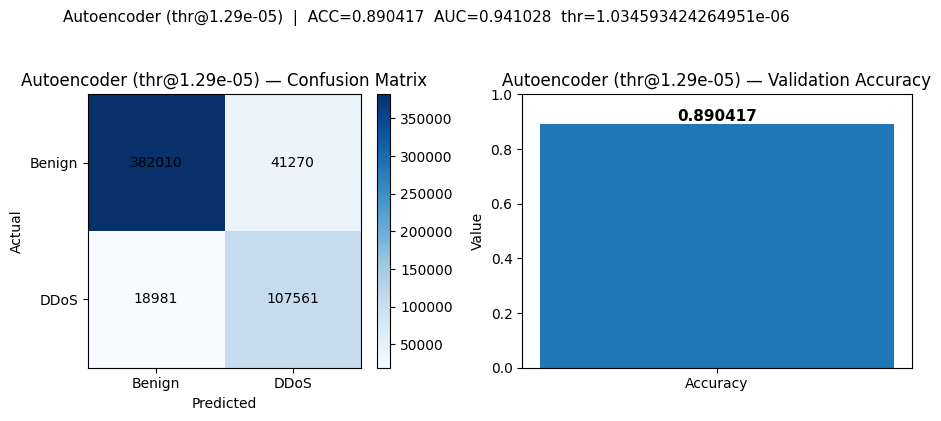

In [11]:
from tensorflow.keras import layers, models, callbacks # type: ignore

# chuẩn bị dữ liệu benign-only
X_train_benign = X_train_s[y_train==0].astype(np.float32)
X_test_s32 = X_test_s.astype(np.float32)

if 'ae' not in globals():
    ae = models.Sequential([
        layers.Input(shape=(X_train_benign.shape[1],)),
        layers.Dense(128, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(X_train_benign.shape[1], activation=None)
    ])
ae.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mse")
ae.fit(X_train_benign, X_train_benign, epochs=20, batch_size=2048,
       validation_split=0.1, callbacks=[callbacks.EarlyStopping(patience=3, restore_best_weights=True)], verbose=0)

# # lỗi tái tạo
# recon_train = np.mean((X_train_benign - ae.predict(X_train_benign, batch_size=4096, verbose=0))**2, axis=1)
# thr = float(np.percentile(recon_train, 95))
# recon_test  = np.mean((X_test_s32 - ae.predict(X_test_s32, batch_size=4096, verbose=0))**2, axis=1)

# # Chuẩn hoá để tính AUC
# yprob_ae = (recon_test - recon_test.min()) / (recon_test.max()-recon_test.min() + 1e-12)
# _ = eval_binary(y_test, yprob_ae, f"Autoencoder (thr@P95={thr:.4g})")

# save_model_h5_any(ae, "Autoencoder_Binary_Phase1", extra={"threshold": thr})
# show_cm_and_valacc(f"Autoencoder (thr@{thr:.4g})", y_test, yprob_ae, threshold=0.5,
#                    savepath=str(DIR_PLOTS / f"AE_Binary_Phase1-{_stamp()}.png"))

# --- lỗi tái tạo ---
recon_train = np.mean((X_train_benign - ae.predict(X_train_benign, batch_size=4096, verbose=0))**2, axis=1)
recon_test  = np.mean((X_test_s32     - ae.predict(X_test_s32,     batch_size=4096, verbose=0))**2, axis=1)

# 1) Ngưỡng “mặc định” theo Benign (P95 trên train-benign)
thr_raw = float(np.percentile(recon_train, 95))

# 2) (Khuyến nghị) Tối ưu ngưỡng theo mục tiêu trên tập test có nhãn
from sklearn.metrics import precision_recall_curve, classification_report, roc_auc_score
def best_thr_by_f1(y_true, scores, min_recall=None):
    # scores càng cao càng “bất thường”
    s = (scores - scores.min()) / (scores.max()-scores.min() + 1e-12)  # chỉ để dùng PR-curve
    p, r, t = precision_recall_curve(y_true, s)
    f1 = 2*p[:-1]*r[:-1]/(p[:-1]+r[:-1] + 1e-9)
    if min_recall is not None:
        mask = r[:-1] >= float(min_recall)
        idx = (np.flatnonzero(mask)[f1[mask].argmax()] if mask.any() else f1.argmax())
    else:
        idx = f1.argmax()
    # map ngược về ngưỡng ở không-gian "scores"
    thr_s_norm = float(t[idx])
    thr_s_raw  = float(thr_s_norm * (scores.max()-scores.min()) + scores.min())
    return thr_s_raw, float(p[idx]), float(r[idx]), float(f1[idx])

# chọn 1 trong 2: dùng thr_raw (P95) hoặc tối ưu theo F1 / ép recall
thr_opt, bp, br, bf1 = best_thr_by_f1(y_test, recon_test, min_recall=0.85)  # có thể None
thr_use = thr_opt  # hoặc: thr_raw

# y_prob để tính AUC (chuẩn hoá nhưng chỉ để ranking)
yprob_ae = (recon_test - recon_test.min()) / (recon_test.max()-recon_test.min() + 1e-12)

# dự đoán theo NGƯỠNG TRÊN “recon_test”
ypred_ae = (recon_test >= thr_use).astype(int)

print(f"[AE] thr_raw(P95)={thr_raw:.3g} | thr_use={thr_use:.3g} | best(P,R,F1)={bp:.3f},{br:.3f},{bf1:.3f}")
print(classification_report(y_test, ypred_ae, target_names=['Benign','DDoS']))
print("ROC-AUC:", roc_auc_score(y_test, yprob_ae))

# đưa vào bảng tổng hợp Phase-1 với đúng ngưỡng
_ = eval_binary(y_test, yprob_ae, f"Autoencoder (thr@{thr_use:.3g})", threshold=
    (thr_use - recon_test.min())/(recon_test.max()-recon_test.min() + 1e-12)
)

# VẼ đúng ngưỡng (chuyển thr_use sang không-gian yprob_ae để vẽ)
thr_plot = (thr_use - recon_test.min())/(recon_test.max()-recon_test.min() + 1e-12)
save_model_h5_any(ae, "Autoencoder_Binary_Phase1", extra={"threshold_raw": thr_use})
show_cm_and_valacc(f"Autoencoder (thr@{thr_use:.3g})", y_test, yprob_ae, threshold=thr_plot,
                   savepath=str(DIR_PLOTS / f"AE_Binary_Phase1-{_stamp()}.png"))



# **Phase 2: Deep Learning (Multiclass — LSTM/GRU/CNN) — Train/Resume + Lưu + Plot**

In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks # type: ignore
from sklearn.metrics import accuracy_score

print("\n=== Phase 2 — Deep Learning (Multiclass AttackType) ===")
EPOCHS_DL2 = 25
BATCH2 = 2048
num_classes = len(le_attack.classes_)
print("Attack classes:", list(le_attack.classes_))

cb2 = [
    callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor="val_accuracy"),
    callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-5)
]

# LSTM
if 'lstm_multi' not in globals():
    lstm_multi = models.Sequential([
        layers.Input(shape=(Xa_tr.shape[1], 1)),
        layers.LSTM(64, return_sequences=True),
        layers.LSTM(32),
        layers.Dense(64, activation="relu"),
        layers.Dense(num_classes, activation="softmax")
    ])
lstm_multi.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
print("\n[Train] LSTM (Multiclass)")
lstm_multi.fit(Xa_tr_dl, ya_tr, epochs=EPOCHS_DL2, batch_size=BATCH2,
               validation_data=(Xa_te_dl, ya_te), callbacks=cb2, verbose=1)
y_pred_lstm = np.argmax(lstm_multi.predict(Xa_te_dl, batch_size=BATCH2, verbose=0), axis=1)
print("LSTM (Multiclass) — Accuracy:", accuracy_score(ya_te, y_pred_lstm))
print(classification_report(ya_te, y_pred_lstm, target_names=le_attack.classes_))
save_model_h5_any(lstm_multi, "LSTM_Multiclass_Phase2", extra={"classes": list(le_attack.classes_)})
show_cm_and_valacc_multiclass("LSTM (Multiclass AttackType)", ya_te, y_pred_lstm, labels=le_attack.classes_,
                              savepath=str(DIR_PLOTS / f"LSTM_Multiclass_Phase2-{_stamp()}.png"))

# GRU
if 'gru_multi' not in globals():
    gru_multi = models.Sequential([
        layers.Input(shape=(Xa_tr.shape[1], 1)),
        layers.GRU(64, return_sequences=True),
        layers.GRU(32),
        layers.Dense(64, activation="relu"),
        layers.Dense(num_classes, activation="softmax")
    ])
gru_multi.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
print("\n[Train] GRU (Multiclass)")
gru_multi.fit(Xa_tr_dl, ya_tr, epochs=EPOCHS_DL2, batch_size=BATCH2,
              validation_data=(Xa_te_dl, ya_te), callbacks=cb2, verbose=1)
y_pred_gru = np.argmax(gru_multi.predict(Xa_te_dl, batch_size=BATCH2, verbose=0), axis=1)
print("GRU (Multiclass) — Accuracy:", accuracy_score(ya_te, y_pred_gru))
print(classification_report(ya_te, y_pred_gru, target_names=le_attack.classes_))
save_model_h5_any(gru_multi, "GRU_Multiclass_Phase2", extra={"classes": list(le_attack.classes_)})
show_cm_and_valacc_multiclass("GRU (Multiclass AttackType)", ya_te, y_pred_gru, labels=le_attack.classes_,
                              savepath=str(DIR_PLOTS / f"GRU_Multiclass_Phase2-{_stamp()}.png"))

# 1D-CNN
if 'cnn_multi' not in globals():
    cnn_multi = models.Sequential([
        layers.Input(shape=(Xa_tr.shape[1], 1)),
        layers.Conv1D(64, kernel_size=5, activation="relu"),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(64, kernel_size=3, activation="relu"),
        layers.GlobalAveragePooling1D(),
        layers.Dense(64, activation="relu"),
        layers.Dense(num_classes, activation="softmax")
    ])
cnn_multi.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
print("\n[Train] 1D-CNN (Multiclass)")
cnn_multi.fit(Xa_tr_dl, ya_tr, epochs=EPOCHS_DL2, batch_size=BATCH2,
              validation_data=(Xa_te_dl, ya_te), callbacks=cb2, verbose=1)
y_pred_cnn = np.argmax(cnn_multi.predict(Xa_te_dl, batch_size=BATCH2, verbose=0), axis=1)
print("1D-CNN (Multiclass) — Accuracy:", accuracy_score(ya_te, y_pred_cnn))
print(classification_report(ya_te, y_pred_cnn, target_names=le_attack.classes_))
save_model_h5_any(cnn_multi, "CNN1D_Multiclass_Phase2", extra={"classes": list(le_attack.classes_)})
show_cm_and_valacc_multiclass("1D-CNN (Multiclass AttackType)", ya_te, y_pred_cnn, labels=le_attack.classes_,
                              savepath=str(DIR_PLOTS / f"CNN1D_Multiclass_Phase2-{_stamp()}.png"))



=== Phase 2 — Deep Learning (Multiclass AttackType) ===
Attack classes: ['Brute Force', 'DoS', 'LDAP', 'MSSQL', 'Other', 'PortScan', 'Syn', 'UDP', 'Web Attack']

[Train] LSTM (Multiclass)
Epoch 1/25
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 785s 640ms/step - accuracy: 0.5376 - loss: 1.2609 - val_accuracy: 0.6944 - val_loss: 0.9156 - learning_rate: 0.0010
Epoch 2/25
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 786s 642ms/step - accuracy: 0.7143 - loss: 0.7936 - val_accuracy: 0.7545 - val_loss: 0.6257 - learning_rate: 0.0010
Epoch 3/25
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 793s 647ms/step - accuracy: 0.7257 - loss: 0.7452 - val_accuracy: 0.7999 - val_loss: 0.5387 - learning_rate: 0.0010
Epoch 4/25
1225/1225 ━━━━━━━━━━━━━━━━━━━━ 797s 650ms/step - accuracy: 0.6655 - loss: 0.9703 - val_accuracy: 0.2564 - val_loss: 1.9091 - learning_rate: 0.0010
Epoch 5/25
 612/1225 ━━━━━━━━━━━━━━━━━━━━ 5:54 578ms/step - accuracy: 0.3052 - loss: 1.7810

KeyboardInterrupt: 


# **FT-Transformer (blocks)**

In [46]:
# %% FT-Transformer building blocks (Keras)
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks # type: ignore

class CLSToken(layers.Layer):
    def __init__(self, d_model, **kwargs):
        super().__init__(**kwargs); self.d_model = d_model
    def build(self, input_shape):
        self.cls = self.add_weight(name="cls_token", shape=(1,1,self.d_model),
                           initializer="zeros", trainable=True)

    def call(self, x):
        b = tf.shape(x)[0]
        return tf.concat([tf.tile(self.cls, [b,1,1]), x], axis=1)

class ColumnEmbedding(layers.Layer):
    def __init__(self, num_features, d_model, **kwargs):
        super().__init__(**kwargs)
        self.num_features = num_features
        self.d_model = d_model

    def build(self, input_shape):
        # Không cộng embedding cho CLS; chỉ cho T = num_features token còn lại
        self.col_embed = self.add_weight(
            name="col_embedding",
            shape=(self.num_features, self.d_model),
            initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02),
            trainable=True,
        )

    def call(self, x_with_cls):
        # x_with_cls: (B, 1 + T, d)
        x_cls = x_with_cls[:, :1, :]
        x_tok = x_with_cls[:, 1:, :]
        emb = tf.expand_dims(self.col_embed, 0)              # (1, T, d)
        emb = tf.tile(emb, [tf.shape(x_tok)[0], 1, 1])       # (B, T, d)
        x_tok = x_tok + emb
        return tf.concat([x_cls, x_tok], axis=1)             # (B, 1+T, d)


def transformer_block(x, d_model=192, num_heads=6, ff_mult=4, dropout=0.1, name="xformer"):
    h = layers.LayerNormalization(epsilon=1e-6, name=f"{name}_ln1")(x)
    h = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads, name=f"{name}_mha")(h, h)
    h = layers.Dropout(dropout, name=f"{name}_drop1")(h)
    x = layers.Add(name=f"{name}_res1")([x, h])

    h = layers.LayerNormalization(epsilon=1e-6, name=f"{name}_ln2")(x)
    h = layers.Dense(d_model*ff_mult, activation="gelu", name=f"{name}_ff1")(h)
    h = layers.Dropout(dropout, name=f"{name}_drop2")(h)
    h = layers.Dense(d_model, name=f"{name}_ff2")(h)
    h = layers.Dropout(dropout, name=f"{name}_drop3")(h)
    return layers.Add(name=f"{name}_res2")([x, h])

def build_ft_transformer(num_features, d_model=192, num_heads=6, depth=4, ff_mult=4,
                         dropout=0.1, out_dim=1, out_activation="sigmoid", name="FTTransformer"):
    inp = layers.Input(shape=(num_features, 1), name=f"{name}_in")
    tok = layers.Conv1D(d_model, kernel_size=1, name=f"{name}_proj")(inp)
    tok = CLSToken(d_model, name=f"{name}_cls")(tok)
    tok = ColumnEmbedding(num_features, d_model, name=f"{name}_colemb")(tok)
    x = tok
    for i in range(depth):
        x = transformer_block(x, d_model, num_heads, ff_mult, dropout, name=f"{name}_blk{i+1}")
    cls = layers.LayerNormalization(epsilon=1e-6, name=f"{name}_ln_out")(x[:, 0])
    cls = layers.Dropout(dropout, name=f"{name}_drop_out")(cls)
    out = layers.Dense(out_dim, activation=out_activation, name=f"{name}_head")(cls)
    return models.Model(inp, out, name=name)

def _save_keras_or_fallback(model, fname):
    # ưu tiên save_model_h5_any nếu bạn đã có ở notebook
    try:
        _ = save_model_h5_any(model, fname)  # type: ignore
        return
    except Exception:
        pass
    # fallback: lưu trực tiếp .h5 vào D:\DACN\results\training\models
    from pathlib import Path
    import time
    ROOT_SAVE = Path(r"D:\DACN\results\training"); (ROOT_SAVE / "models").mkdir(parents=True, exist_ok=True)
    ts = time.strftime("%Y%m%d-%H%M%S")
    path = ROOT_SAVE / "models" / f"{fname}-{ts}.h5"
    model.save(path)
    print(f"[SAVE] Keras -> {path}")


# **FT-Transformer Phase-1 (Binary)**

In [ ]:
# %% FT-Transformer — Phase-1 (Binary) with tf.data (no giant 3D arrays)
import gc, numpy as np, tensorflow as tf
from tensorflow.keras import callbacks # type: ignore

# 1) Giải phóng 3D arrays cũ (nếu có)
for v in ["X_train_dl","X_test_dl"]:
    if v in globals():
        try: del globals()[v]
        except: pass
gc.collect()

assert 'X_train_s' in globals() and 'X_test_s' in globals()
assert 'y_train'   in globals() and 'y_test'   in globals()

AUTOTUNE = tf.data.AUTOTUNE

def make_ds(X2d, y, batch):
    ds = tf.data.Dataset.from_tensor_slices((X2d, y))
    ds = ds.map(
        lambda x, t: (tf.expand_dims(tf.cast(x, tf.float32), -1), tf.cast(t, tf.float32)),
        num_parallel_calls=AUTOTUNE
    )
    return ds.batch(batch).prefetch(AUTOTUNE)

def train_ft_binary(d_model=128, num_heads=4, depth=3, ff_mult=2, dropout=0.15, batch=512, epochs=25):
    num_features = X_train_s.shape[1]
    model = build_ft_transformer(
        num_features=num_features, d_model=d_model, num_heads=num_heads, depth=depth,
        ff_mult=ff_mult, dropout=dropout, out_dim=1, out_activation="sigmoid",
        name="FTTransformer_Binary"
    )
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss="binary_crossentropy",
                  metrics=[tf.keras.metrics.AUC(name="auc")])

    cb = [
        callbacks.EarlyStopping(patience=4, restore_best_weights=True, monitor="val_auc", mode="max"),
        callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-5, monitor="val_auc", mode="max"),
    ]

    print(model.summary())
    ds_tr = make_ds(X_train_s, y_train, batch)
    ds_te = make_ds(X_test_s,  y_test,  batch)

    hist = model.fit(ds_tr, epochs=epochs, validation_data=ds_te, verbose=1, callbacks=cb)
    return model, hist, ds_te, batch

# 2) Tự hạ tài nguyên khi thiếu RAM
candidates = [
    {"d_model":128,"num_heads":4,"depth":3,"ff_mult":2,"batch":512},
    {"d_model":128,"num_heads":4,"depth":3,"ff_mult":2,"batch":256},
    {"d_model":96, "num_heads":3,"depth":3,"ff_mult":2,"batch":256},
    {"d_model":96, "num_heads":3,"depth":2,"ff_mult":2,"batch":256},
    {"d_model":64, "num_heads":2,"depth":2,"ff_mult":2,"batch":128},
]

ft_bin = ds_te = None
last_batch = 256
for cfg in candidates:
    try:
        print(f"[TRY] d_model={cfg['d_model']} heads={cfg['num_heads']} depth={cfg['depth']} "
              f"ff_mult={cfg['ff_mult']} batch={cfg['batch']}")
        ft_bin, hist, ds_te, last_batch = train_ft_binary(**cfg)
        print("[OK] Train done.")
        break
    except (tf.errors.ResourceExhaustedError, MemoryError) as e:
        print(f"[MEM] {type(e).__name__}: hạ cấu hình và thử lại…")
        tf.keras.backend.clear_session(); gc.collect()
        continue
if ft_bin is None:
    raise RuntimeError("Thiếu RAM cho FT-Transformer. Giảm thêm d_model/depth hoặc batch.")

# 3) Predict + Eval + Plot + Save
yprob_ft_bin = ft_bin.predict(ds_te, verbose=0).ravel()
_ = eval_binary(y_test, yprob_ft_bin, "FT-Transformer (Binary)")

try:
    show_cm_and_valacc("FT-Transformer (Binary)", y_test, yprob_ft_bin, threshold=0.5,
                       savepath=str(DIR_PLOTS / f"FTTransformer_Binary_Phase1-{_stamp()}.png"))
except Exception:
    show_cm_and_valacc("FT-Transformer (Binary)", y_test, yprob_ft_bin, threshold=0.5)

_save_keras_or_fallback(ft_bin, "FTTransformer_Binary_Phase1")

[TRY] d_model=128 heads=4 depth=3 ff_mult=2 batch=512


Model: "FTTransformer_Binary"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ FTTransformer_Bina… │ (None, 156, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FTTransformer_Bina… │ (None, 156, 128)  │        256 │ FTTransformer_Bi… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FTTransformer_Bina… │ (None, 157, 128)  │        128 │ FTTransformer_Bi… │
│ (CLSToken)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FTTransformer_Bina… │ (None, 157, 128)  │     19,968 │ FTTransformer_Bi… │
│ (ColumnEmbedding)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FTTransformer_Bina… │ (None, 157, 128)  │        256 │ FTTransformer_Bi… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FTTransformer_Bina… │ (None, 157, 128)  │     66,048 │ FTTransformer_Bi… │
│ (MultiHeadAttentio… │                   │            │ FTTransformer_Bi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FTTransformer_Bina… │ (None, 157, 128)  │          0 │ FTTransformer_Bi… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FTTransformer_Bina… │ (None, 157, 128)  │          0 │ FTTransformer_Bi… │
│ (Add)               │                   │            │ FTTransformer_Bi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FTTransformer_Bina… │ (None, 157, 128)  │        256 │ FTTransformer_Bi… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FTTransformer_Bina… │ (None, 157, 256)  │     33,024 │ FTTransformer_Bi… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FTTransformer_Bina… │ (None, 157, 256)  │          0 │ FTTransformer_Bi… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FTTransformer_Bina… │ (None, 157, 128)  │     32,896 │ FTTransformer_Bi… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FTTransformer_Bina… │ (None, 157, 128)  │          0 │ FTTransformer_Bi… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FTTransformer_Bina… │ (None, 157, 128)  │          0 │ FTTransformer_Bi… │
│ (Add)               │                   │            │ FTTransformer_Bi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FTTransformer_Bina… │ (None, 157, 128)  │        256 │ FTTransformer_Bi… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FTTransformer_Bina… │ (None, 157, 128)  │     66,048 │ FTTransformer_Bi… │
│ (MultiHeadAttentio… │                   │            │ FTTransformer_Bi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FTTransformer_Bina… │ (None, 157, 128)  │          0 │ FTTransformer_Bi

 Total params: 418,177 (1.60 MB)

 Trainable params: 418,177 (1.60 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/25
 163/4296 ━━━━━━━━━━━━━━━━━━━━ 2:49:12 2s/step - auc: 0.7633 - loss: 0.4556

KeyboardInterrupt: 

# **FT-Transformer Phase-2**

In [ ]:
# %% FT-Transformer — Phase-2 (Multiclass AttackType)
# Dùng Xa_tr_dl, Xa_te_dl, ya_tr, ya_te, le_attack đã sẵn trong notebook

import tensorflow as tf
from tensorflow.keras import callbacks # type: ignore
from sklearn.metrics import classification_report, accuracy_score

num_features_mc = Xa_tr_dl.shape[1]
num_classes = len(le_attack.classes_)

ft_mul = build_ft_transformer(
    num_features=num_features_mc, d_model=224, num_heads=8, depth=5,
    ff_mult=4, dropout=0.15, out_dim=num_classes, out_activation="softmax",
    name="FTTransformer_Multiclass"
)
ft_mul.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
               loss="sparse_categorical_crossentropy",
               metrics=["accuracy"])

cb2 = [
    callbacks.EarlyStopping(patience=4, restore_best_weights=True, monitor="val_accuracy"),
    callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-5)
]

print(ft_mul.summary())
ft_mul.fit(Xa_tr_dl, ya_tr,
           epochs=30, batch_size=2048,
           validation_data=(Xa_te_dl, ya_te),
           callbacks=cb2, verbose=1)

# Predict + Eval + Plot + Save
y_pred_ft_mul = tf.argmax(ft_mul.predict(Xa_te_dl, batch_size=2048, verbose=0), axis=1).numpy()
print("\nFT-Transformer (Multiclass) — Accuracy:", accuracy_score(ya_te, y_pred_ft_mul))
print(classification_report(ya_te, y_pred_ft_mul, target_names=le_attack.classes_))

try:
    show_cm_and_valacc_multiclass("FT-Transformer (Multiclass AttackType)",
                                  ya_te, y_pred_ft_mul, labels=le_attack.classes_,
                                  savepath=str(DIR_PLOTS / f"FTTransformer_Multiclass_Phase2-{_stamp()}.png"))
except Exception:
    show_cm_and_valacc_multiclass("FT-Transformer (Multiclass AttackType)",
                                  ya_te, y_pred_ft_mul, labels=le_attack.classes_)

_save_keras_or_fallback(ft_mul, "FTTransformer_Multiclass_Phase2")


# **CatBoost Phase 1**

CatBoost is using more CPU RAM (21.3GiB) than the limit (18GiB)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(3013112) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(3013112) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(3013112) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(3013112) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(3013112) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(3013112) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(3013112) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(3013112) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(3013112) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(3013112) > ResourceQuota(0)
Resource CPU RAM: functionWithResourceUsage.ResourceUsage(3013112) > Resourc

0:	test: 0.9850795	best: 0.9850795 (0)	total: 707ms	remaining: 14m 7s
200:	test: 0.9999654	best: 0.9999654 (200)	total: 1m 51s	remaining: 9m 12s
400:	test: 0.9999781	best: 0.9999781 (398)	total: 3m 45s	remaining: 7m 28s
600:	test: 0.9999812	best: 0.9999812 (600)	total: 5m 33s	remaining: 5m 32s
800:	test: 0.9999821	best: 0.9999821 (799)	total: 7m 12s	remaining: 3m 35s
1000:	test: 0.9999826	best: 0.9999826 (988)	total: 8m 48s	remaining: 1m 45s
1199:	test: 0.9999829	best: 0.9999829 (1196)	total: 10m 21s	remaining: 0us

bestTest = 0.9999829394
bestIteration = 1196

Shrink model to first 1197 iterations.
[INFO] CatBoost train mode = full

=== CatBoost (Binary, full) ===
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00    423280
        DDoS       1.00      1.00      1.00    126542

    accuracy                           1.00    549822
   macro avg       1.00      1.00      1.00    549822
weighted avg       1.00      1.00      1.00    549822


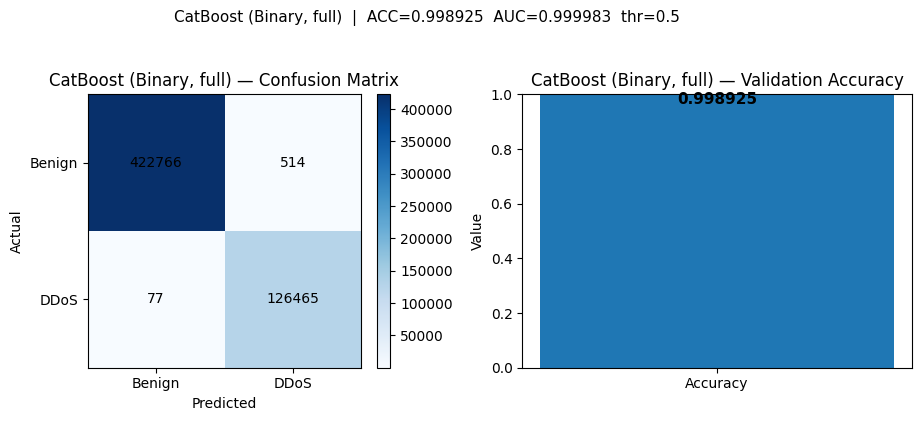

In [ ]:
# %% Phase-1 — CatBoost (Binary, RAM-safe + fallback)
from catboost import CatBoostClassifier, Pool, CatBoostError
import numpy as np
from pathlib import Path
import gc, traceback

ROOT_SAVE  = Path(r"D:\DACN\results\training")
DIR_MODELS = ROOT_SAVE / "models"
DIR_PLOTS  = ROOT_SAVE / "plots"
DIR_MODELS.mkdir(parents=True, exist_ok=True)
DIR_PLOTS.mkdir(parents=True, exist_ok=True)

# ===== cấu hình cơ sở: tiết kiệm RAM (CPU). Nếu bạn đã cài CatBoost GPU CUDA, set USE_GPU=True.
USE_GPU = False  # True nếu đã cài CatBoost GPU và muốn dùng GTX 3050 Ti
BASE_PARAMS = dict(
    loss_function="Logloss",
    eval_metric="AUC",
    learning_rate=0.06,            # hơi nhanh để giảm iterations
    iterations=1200,               # 2000 -> 1200 (bạn có thể tăng lại nếu ổn)
    depth=6,                       # 8 -> 6 (giảm RAM)
    l2_leaf_reg=3.0,
    random_seed=42,
    od_type="Iter",
    od_wait=100,
    auto_class_weights="Balanced", # cân lớp tự động, KHÔNG cần SMOTE
    rsm=0.8,                       # colsample (feature subsampling)
    subsample=0.85,                # row subsampling
    border_count=96,               # số bin cho numeric (254 -> 96 giảm RAM đáng kể)
    grow_policy="Lossguide",       # ít RAM hơn SymmetricTree
    min_data_in_leaf=64,
    used_ram_limit="18gb",         # giới hạn RAM
    verbose=200
)
if USE_GPU:
    BASE_PARAMS.update(task_type="GPU", devices="0", gpu_ram_part=0.9)
else:
    BASE_PARAMS.update(task_type="CPU", thread_count=-1)

# ===== helper: train với params, nếu OOM thì giảm cấu hình hoặc lấy mẫu
def train_catboost_safe(Xtr, ytr, Xva, yva):
    train_pool = Pool(Xtr, label=ytr)
    valid_pool = Pool(Xva, label=yva)

    params = BASE_PARAMS.copy()
    cat = CatBoostClassifier(**params)
    try:
        cat.fit(train_pool, eval_set=valid_pool, use_best_model=True)
        return cat, "full"
    except CatBoostError as e:
        print("[WARN] CatBoost OOM trên cấu hình cơ sở. Thử cấu hình nhẹ hơn...")
        # 1) giảm iterations/depth/border_count thêm
        params.update(iterations=900, depth=6, border_count=64, rsm=0.7, subsample=0.8, min_data_in_leaf=128)
        cat = CatBoostClassifier(**params)
        try:
            cat.fit(train_pool, eval_set=valid_pool, use_best_model=True)
            return cat, "reduced_params"
        except CatBoostError as e2:
            print("[WARN] Vẫn OOM. Thử lấy mẫu dưới.")
            # 2) fallback: lấy mẫu train để đảm bảo chạy (như bạn làm với RF)
            MAX_TRAIN_SAMPLES = 800_000
            rng = np.random.RandomState(42)
            idx = rng.choice(len(Xtr), size=min(MAX_TRAIN_SAMPLES, len(Xtr)), replace=False)
            Xsub, ysub = Xtr[idx], ytr[idx]
            train_pool2 = Pool(Xsub, label=ysub)

            params.update(iterations=800, depth=6, border_count=64, rsm=0.7, subsample=0.8, min_data_in_leaf=128)
            cat = CatBoostClassifier(**params)
            cat.fit(train_pool2, eval_set=valid_pool, use_best_model=True)
            return cat, f"sampled({len(Xsub)})"
    except Exception as ex:
        print("[ERROR] Không lường trước:", ex)
        traceback.print_exc()
        raise

# ===== Train (tự động chọn chiến lược an toàn)
cat_bin, mode = train_catboost_safe(X_train_s, y_train, X_test_s, y_test)
print(f"[INFO] CatBoost train mode = {mode}")

# ===== Predict + log Phase-1
yprob_cat = cat_bin.predict_proba(X_test_s)[:, 1]
_ = eval_binary(y_test, yprob_cat, f"CatBoost (Binary, {mode})")

# ===== Save model (.cbm + pack .h5)
cbm_path = DIR_MODELS / f"CatBoost_Binary_Phase1-{_stamp()}.cbm"
cat_bin.save_model(cbm_path.as_posix())
print(f"[SAVE] CatBoost native -> {cbm_path}")

pack = {"model": cat_bin, "scaler": scaler, "feature_order": feature_candidates}
save_model_h5_any(pack, "CatBoost_Binary_Phase1")

# ===== Plot CM + ValAcc
show_cm_and_valacc(
    f"CatBoost (Binary, {mode})", y_test, yprob_cat, threshold=0.5,
    savepath=str(DIR_PLOTS / f"CatBoost_Binary_Phase1-{_stamp()}.png")
)
gc.collect();


[CatBoost Binary] threshold=0.50 | Val-ACC=0.9989 | ROC-AUC=0.999983
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00    423280
        DDoS       1.00      1.00      1.00    126542

    accuracy                           1.00    549822
   macro avg       1.00      1.00      1.00    549822
weighted avg       1.00      1.00      1.00    549822



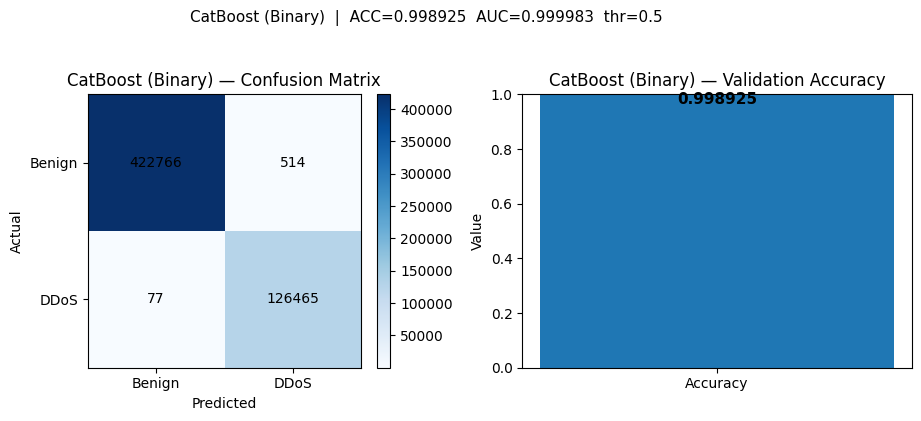

[PLOT] Saved -> D:\DACN\results\training\plots\CatBoost_Binary_Phase1-20251009-010146.png
[SAVE] CM CSV -> D:\DACN\results\training\tables\CatBoost_Binary_Phase1_cm-20251009-010147.csv
[SAVE] Metrics -> D:\DACN\results\training\tables\CatBoost_Binary_Phase1_metrics-20251009-010147.json


In [13]:
# %% Phase-1 — CatBoost (Binary) — CM + Val + Save
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report
from pathlib import Path
import pandas as pd, json
import numpy as np

# folders
ROOT_SAVE  = Path(r"D:\DACN\results\training")
DIR_PLOTS  = ROOT_SAVE / "plots"
DIR_TABLES = ROOT_SAVE / "tables"
DIR_PLOTS.mkdir(parents=True, exist_ok=True)
DIR_TABLES.mkdir(parents=True, exist_ok=True)

# --- chọn ngưỡng (giữ 0.5; nếu muốn auto-best F1 thì thay bằng find_best_threshold của bạn)
THRESH = 0.5

# --- predictions & metrics
y_pred = (yprob_cat >= THRESH).astype(int)
val_acc = accuracy_score(y_test, y_pred)
rocauc  = roc_auc_score(y_test, yprob_cat)
cm      = confusion_matrix(y_test, y_pred)

print(f"[CatBoost Binary] threshold={THRESH:.2f} | Val-ACC={val_acc:.4f} | ROC-AUC={rocauc:.6f}")
print(classification_report(y_test, y_pred, target_names=["Benign","DDoS"]))

# --- plot + save (dùng helper của bạn)
plot_path = DIR_PLOTS / f"CatBoost_Binary_Phase1-{_stamp()}.png"
show_cm_and_valacc("CatBoost (Binary)", y_test, yprob_cat, threshold=THRESH, savepath=str(plot_path))
print(f"[PLOT] Saved -> {plot_path}")

# --- save CM table (.csv) + metrics (.json) để tổng hợp về sau
cm_df = pd.DataFrame(cm, index=["True_Benign","True_DDoS"], columns=["Pred_Benign","Pred_DDoS"])
cm_csv = DIR_TABLES / f"CatBoost_Binary_Phase1_cm-{_stamp()}.csv"
cm_df.to_csv(cm_csv, index=True)

metrics = {"threshold": THRESH, "val_acc": float(val_acc), "roc_auc": float(rocauc)}
metrics_json = DIR_TABLES / f"CatBoost_Binary_Phase1_metrics-{_stamp()}.json"
with open(metrics_json, "w", encoding="utf-8") as f:
    json.dump(metrics, f, ensure_ascii=False, indent=2)

print(f"[SAVE] CM CSV -> {cm_csv}")
print(f"[SAVE] Metrics -> {metrics_json}")


# **Phase 2 Catboost**

In [ ]:
# %% Phase-2 — CatBoost Multiclass (GPU first, CPU fallback) — epoch + stop AUC (latest model)
from catboost import CatBoostClassifier, Pool, CatBoostError
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
import numpy as np, time, gc, os
from collections import deque

# --- downcast để tiết kiệm RAM/VRAM ---
def _down(a):
    if a.dtype == np.float64: a = a.astype(np.float32, copy=False)
    if a.dtype == np.int64:   a = a.astype(np.int32,   copy=False)
    return np.ascontiguousarray(a)
Xa_tr=_down(Xa_tr); Xa_te=_down(Xa_te)
ya_tr=ya_tr.astype(np.int32, copy=False); ya_te=ya_te.astype(np.int32, copy=False)

# --- tham số chung cho vòng epoch ---
max_iterations   = 4000
block_iterations = 200
metric_period    = 100
min_delta_auc    = 1e-4
patience_epochs  = 3

def train_epoch_style(BASE):
    train_pool, valid_pool = Pool(Xa_tr, ya_tr), Pool(Xa_te, ya_te)
    prev_model=None; total=0; epoch=0
    auc_hist=[]; deltas=deque(maxlen=patience_epochs)

    t0=time.time()
    while total < max_iterations:
        epoch += 1
        iters = min(block_iterations, max_iterations-total)
        params = {**BASE, "iterations": total+iters, "metric_period": metric_period}  # không set logging_level khi đã có verbose

        m = CatBoostClassifier(**params)
        m.fit(train_pool, eval_set=valid_pool, init_model=prev_model, use_best_model=False)

        proba = m.predict_proba(Xa_te)
        auc   = roc_auc_score(ya_te, proba, multi_class="ovr", average="macro")
        auc_hist.append(float(auc))

        total += iters
        print(f"Epoch {epoch}/{(max_iterations+block_iterations-1)//block_iterations} "
              f"{iters}/{max_iterations} — val_AUC(ovr): {auc:.6f}")

        if len(auc_hist) >= 2:
            deltas.append(abs(auc_hist[-1]-auc_hist[-2]))

        prev_model = m  # dùng model MỚI NHẤT theo yêu cầu
        del proba, m; gc.collect()

        if len(deltas)==patience_epochs and all(d < min_delta_auc for d in deltas):
            print(f"[EARLY STOP] AUC đổi < {min_delta_auc} trong {patience_epochs} epoch. Dùng model MỚI NHẤT.")
            break

    return prev_model, auc_hist[-1], total

# --------- Cấu hình GPU cho GTX 3050 Ti (KHÔNG có rsm) ----------
BASE_GPU = dict(
    loss_function="MultiClass",
    eval_metric="MultiClass",
    depth=6,
    learning_rate=0.06,
    l2_leaf_reg=6.0,
    bootstrap_type="Bernoulli", subsample=0.8,
    # rsm: KHÔNG dùng trên GPU
    border_count=32,                 # nếu VRAM thiếu: 32
    grow_policy="Depthwise",
    random_seed=RANDOM_STATE,
    task_type="GPU", devices="0",
    verbose=False
)

# --------- Cấu hình CPU an toàn (có rsm) ----------
BASE_CPU = dict(
    loss_function="MultiClass",
    eval_metric="MultiClass",
    depth=6,
    learning_rate=0.06,
    l2_leaf_reg=6.0,
    bootstrap_type="Bernoulli", subsample=0.8,
    rsm=0.8,                         # chỉ dùng CPU
    border_count=64,
    grow_policy="Depthwise",
    random_seed=RANDOM_STATE,
    task_type="CPU",
    thread_count=10,                 # 12700H: 8–12 threads hợp lý
    verbose=False
)

# ---- Thử GPU trước, lỗi thì fallback CPU ----
try:
    cb_multi, last_auc, used_iters = train_epoch_style(BASE_GPU)
    print(f"[GPU OK] last val AUC={last_auc:.6f} @ trees={used_iters}")
except CatBoostError as e:
    print("[GPU FAIL] Fallback CPU. Lý do:", e)
    # CPU fallback với tham số nhẹ RAM
    BASE_CPU['border_count'] = 32
    BASE_CPU['depth'] = 5
    cb_multi, last_auc, used_iters = train_epoch_style(BASE_CPU)
    print(f"[CPU OK] last val AUC={last_auc:.6f} @ trees={used_iters}")

# ---- Đánh giá + lưu như quy ước của bạn ----
ya_pred = cb_multi.predict(Xa_te).reshape(-1).astype(int)
print("\nCatBoost (Multiclass) — Accuracy:", accuracy_score(ya_te, ya_pred))
print(classification_report(ya_te, ya_pred, target_names=le_attack.classes_))

try:
    savepath = str(DIR_PLOTS / f"CatBoost_Multiclass_Phase2-{_stamp()}.png")
    show_cm_and_valacc_multiclass("CatBoost (Multiclass AttackType)",
                                  ya_te, ya_pred, labels=le_attack.classes_, savepath=savepath)
    print("[OK] Plot:", savepath)
except Exception:
    show_cm_and_valacc_multiclass("CatBoost (Multiclass AttackType)",
                                  ya_te, ya_pred, labels=le_attack.classes_)

save_model_h5_any(cb_multi, "CatBoost_Multiclass_Phase2",
                  extra={"classes": list(le_attack.classes_),
                         "feature_order": feature_candidates})


RuntimeError: CatBoost GPU error. Nếu gặp OOM: border_count=32, depth=5, block_iterations=100. Gốc: catboost/private/libs/options/catboost_options.cpp:637: Error: rsm on GPU is supported for pairwise modes only

In [ ]:
# %% DCN v2 — Phase-2 (Multiclass AttackType)
# Yêu cầu sẵn có: Xa_tr, Xa_te, ya_tr, ya_te, le_attack, DIR_PLOTS, _stamp,
# save_model_h5_any, show_cm_and_valacc_multiclass, feature_candidates
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks # type: ignore
from sklearn.metrics import classification_report, accuracy_score

def DCN_v2_block(x, depth=4, name="dcn_mc"):
    """Cross Network v2: x_{l+1} = x0 * (W_l x_l) + b_l + x_l"""
    x0 = x
    for i in range(depth):
        xl = layers.Dense(x.shape[-1], use_bias=True, name=f"{name}_w{i+1}")(x)
        x  = layers.Add(name=f"{name}_add{i+1}")([x0 * xl, x])
    return x

num_classes = len(le_attack.classes_)

inp = layers.Input(shape=(Xa_tr.shape[1],))
# Cross (wide)
cross = DCN_v2_block(inp, depth=4, name="dcn_mc")
# Deep
deep = layers.Dense(256, activation="relu")(inp)
deep = layers.Dropout(0.2)(deep)
deep = layers.Dense(128, activation="relu")(deep)
deep = layers.Dropout(0.2)(deep)
deep = layers.Dense(64, activation="relu")(deep)
# Kết hợp
h = layers.Concatenate()([cross, deep])
h = layers.Dense(128, activation="relu")(h)
out = layers.Dense(num_classes, activation="softmax")(h)

dcn_mc = models.Model(inp, out, name="DCNv2_Multiclass")
dcn_mc.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
               loss="sparse_categorical_crossentropy",
               metrics=["accuracy"])

cb2 = [
    callbacks.EarlyStopping(patience=4, restore_best_weights=True, monitor="val_accuracy"),
    callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-5),
]

dcn_mc.fit(Xa_tr, ya_tr, epochs=30, batch_size=2048,
           validation_data=(Xa_te, ya_te), callbacks=cb2, verbose=1)

ya_pred_dcn = tf.argmax(dcn_mc.predict(Xa_te, batch_size=4096, verbose=0), axis=1).numpy()

print("\nDCN v2 (Multiclass) — Accuracy:", accuracy_score(ya_te, ya_pred_dcn))
print(classification_report(ya_te, ya_pred_dcn, target_names=le_attack.classes_))

try:
    show_cm_and_valacc_multiclass("DCN v2 (Multiclass AttackType)",
                                  ya_te, ya_pred_dcn, labels=le_attack.classes_,
                                  savepath=str(DIR_PLOTS / f"DCNv2_Multiclass_Phase2-{_stamp()}.png"))
except Exception:
    show_cm_and_valacc_multiclass("DCN v2 (Multiclass AttackType)",
                                  ya_te, ya_pred_dcn, labels=le_attack.classes_)

save_model_h5_any(dcn_mc, "DCNv2_Multiclass_Phase2",
                  extra={"classes": list(le_attack.classes_),
                         "feature_order": feature_candidates})


AttributeError: 'NoneType' object has no attribute 'classes_'


# **Tổng hợp Phase-1 (Binary)**

,Model,ACC,Precision,Recall,F1,AUC
0,"CatBoost (Binary, full)",0.9989,0.9960,0.9994,0.9977,0.99998


[SAVE] Phase-1 summary -> D:\DACN\results\training\tables\summary_phase1_binary-20251008-232420.csv
[SAVE] Figure -> D:\DACN\results\training\plots\summary_phase1_binary-20251008-232420.png


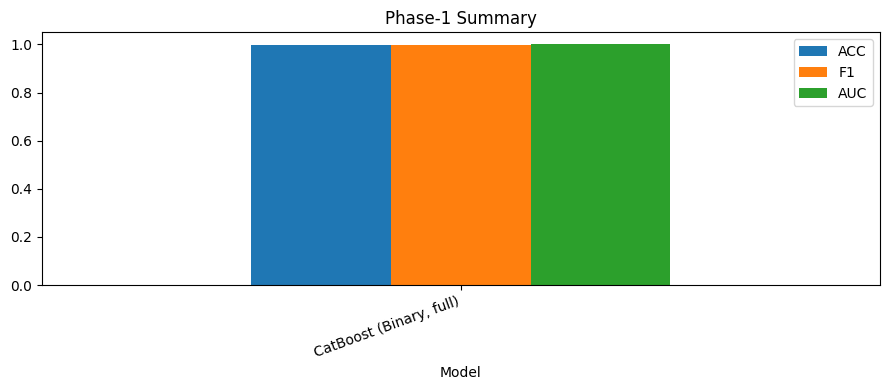

In [13]:
# df_bin = pd.DataFrame(RESULTS_BIN).sort_values(["AUC","F1","ACC"], ascending=False)
# display(df_bin.style.format({"ACC":"{:.4f}","Precision":"{:.4f}","Recall":"{:.4f}","F1":"{:.4f}","AUC":"{:.5f}"}))

# csv_path = DIR_TABLES / f"summary_phase1_binary-{_stamp()}.csv"
# df_bin.to_csv(csv_path, index=False, encoding="utf-8-sig")
# print(f"[SAVE] Phase-1 summary -> {csv_path}")

# ax = df_bin.plot(x="Model", y=["ACC","F1","AUC"], kind="bar", figsize=(9,4))
# plt.title("Phase-1 Summary"); plt.xticks(rotation=20, ha="right"); plt.tight_layout()
# save_fig_current(ax.get_figure(), "summary_phase1_binary")
# plt.show()

# ==== Phase-1 (Binary) summary – bản an toàn hơn (tuỳ chọn) ====
if "RESULTS_BIN" not in globals():
    RESULTS_BIN = []

df_bin = pd.DataFrame(RESULTS_BIN)
if df_bin.empty:
    print("[INFO] Chưa có kết quả Phase-1. Hãy đảm bảo đã gọi eval_binary(...) cho các model.")
else:
    df_bin = df_bin.sort_values(["AUC","F1","ACC"], ascending=False)
    display(df_bin.style.format({"ACC":"{:.4f}","Precision":"{:.4f}","Recall":"{:.4f}","F1":"{:.4f}","AUC":"{:.5f}"}))
    csv_path = DIR_TABLES / f"summary_phase1_binary-{_stamp()}.csv"
    df_bin.to_csv(csv_path, index=False, encoding="utf-8-sig")
    print(f"[SAVE] Phase-1 summary -> {csv_path}")
    ax = df_bin.plot(x="Model", y=["ACC","F1","AUC"], kind="bar", figsize=(9,4))
    plt.title("Phase-1 Summary"); plt.xticks(rotation=20, ha="right"); plt.tight_layout()
    save_fig_current(ax.get_figure(), "summary_phase1_binary")
    plt.show()



# **Tổng hợp Phase-2 (Multiclass)**

,Model,ACC
0,LSTM (Multiclass),0.9982


[SAVE] Phase-2 summary -> D:\DACN\results\training\tables\summary_phase2_multiclass-20251008-205825.csv
[SAVE] Figure -> D:\DACN\results\training\plots\summary_phase2_multiclass-20251008-205825.png


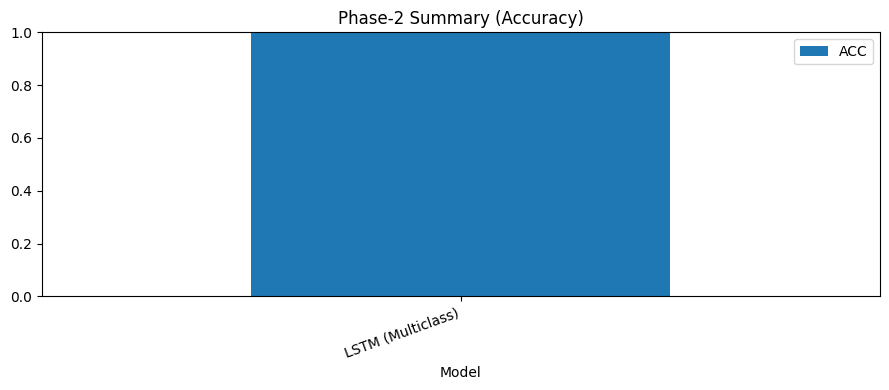

In [52]:
# RESULTS_MULTI = []
# from sklearn.metrics import accuracy_score

# # LGBM (đánh giá trên y_attack_test/y_attack_pred như logic gốc)
# RESULTS_MULTI.append({"Model":"LGBM (Multiclass)","ACC": accuracy_score(y_attack_test, y_attack_pred)})
# RESULTS_MULTI.append({"Model":"XGBoost (Multiclass)","ACC": accuracy_score(ya_te, ya_pred)})
# RESULTS_MULTI.append({"Model":"RandomForest (Multiclass)","ACC": accuracy_score(ya_te, ya_pred_rf)})
# RESULTS_MULTI.append({"Model":"LSTM (Multiclass)","ACC": accuracy_score(ya_te, y_pred_lstm)})
# RESULTS_MULTI.append({"Model":"GRU (Multiclass)","ACC": accuracy_score(ya_te, y_pred_gru)})
# RESULTS_MULTI.append({"Model":"1D-CNN (Multiclass)","ACC": accuracy_score(ya_te, y_pred_cnn)})

# df_multi = pd.DataFrame(RESULTS_MULTI).sort_values("ACC", ascending=False)
# display(df_multi.style.format({"ACC":"{:.4f}"}))

# csv_path2 = DIR_TABLES / f"summary_phase2_multiclass-{_stamp()}.csv"
# df_multi.to_csv(csv_path2, index=False, encoding="utf-8-sig")
# print(f"[SAVE] Phase-2 summary -> {csv_path2}")

# ax2 = df_multi.plot(x="Model", y="ACC", kind="bar", figsize=(9,4))
# plt.title("Phase-2 Summary (Accuracy)"); plt.xticks(rotation=20, ha="right"); plt.ylim(0,1.0); plt.tight_layout()
# save_fig_current(ax2.get_figure(), "summary_phase2_multiclass")
# plt.show()

# ==== Phase-2 (Multiclass) summary – bản an toàn hơn (tuỳ chọn) ====
from sklearn.metrics import accuracy_score
RESULTS_MULTI = []

def add_acc(name, y_true_var, y_pred_var):
    if y_true_var in globals() and y_pred_var in globals():
        try:
            RESULTS_MULTI.append({"Model": name, "ACC": accuracy_score(globals()[y_true_var], globals()[y_pred_var])})
        except Exception as e:
            print(f"[WARN] {name}: {e}")

# Giữ logic gốc + tự động bỏ qua model chưa có biến
add_acc("LGBM (Multiclass)", "y_attack_test", "y_attack_pred")
add_acc("XGBoost (Multiclass)", "ya_te", "ya_pred")
add_acc("RandomForest (Multiclass)", "ya_te", "ya_pred_rf")
add_acc("LSTM (Multiclass)", "ya_te", "y_pred_lstm")
add_acc("GRU (Multiclass)", "ya_te", "y_pred_gru")
add_acc("1D-CNN (Multiclass)", "ya_te", "y_pred_cnn")
# Nếu bạn thêm FT-Transformer Multiclass, bật dòng sau:
add_acc("FT-Transformer (Multiclass)", "ya_te", "y_pred_ft_mul")

df_multi = pd.DataFrame(RESULTS_MULTI)
if df_multi.empty:
    print("[INFO] Chưa có kết quả Phase-2. Hãy train các model multiclass trước.")
else:
    df_multi = df_multi.sort_values("ACC", ascending=False)
    display(df_multi.style.format({"ACC":"{:.4f}"}))
    csv_path2 = DIR_TABLES / f"summary_phase2_multiclass-{_stamp()}.csv"
    df_multi.to_csv(csv_path2, index=False, encoding="utf-8-sig")
    print(f"[SAVE] Phase-2 summary -> {csv_path2}")
    ax2 = df_multi.plot(x="Model", y="ACC", kind="bar", figsize=(9,4))
    plt.title("Phase-2 Summary (Accuracy)"); plt.xticks(rotation=20, ha="right"); plt.ylim(0,1.0); plt.tight_layout()
    save_fig_current(ax2.get_figure(), "summary_phase2_multiclass")
    plt.show()


# **Dọn Ram**

In [ ]:
import gc, sys, types, numpy as np, pandas as pd

KEEP = {
    # artifacts cần giữ
    "feature_candidates", "scaler", "le_attack",
    "xgb_bin","lgb_bin","cat_bin","lstm","gru","cnn","ae",
    "metrics_phase1","metrics_phase2","best_thresholds",
    # config/seed
    "RANDOM_STATE","split_info"
}

SIZE_MB_THRESHOLD = 100  # chỉ dọn biến > 100MB để an toàn

def nbytes(obj):
    try:
        if isinstance(obj, np.ndarray): return obj.nbytes
        if isinstance(obj, pd.DataFrame): return obj.memory_usage(deep=True).sum()
        if isinstance(obj, pd.Series): return obj.memory_usage(deep=True)
        return sys.getsizeof(obj)
    except Exception:
        return 0

deleted = []
for name, val in list(globals().items()):
    if name.startswith("_") or name in KEEP: 
        continue
    if isinstance(val, types.ModuleType) or isinstance(val, types.FunctionType):
        continue
    try:
        mb = nbytes(val) / (1024**2)
        if mb >= SIZE_MB_THRESHOLD:
            del globals()[name]
            deleted.append((name, f"{mb:.1f} MB"))
    except Exception:
        pass

gc.collect()
print("Đã dọn:", deleted[:10], "... tổng:", len(deleted))


Đã dọn: [('dfUN', '83.4 MB'), ('dfUN_ddos', '83.4 MB')] ... tổng: 2
